# Analyse der Strassenverkehrssicherheit in der Schweiz: Fokus auf ältere Verkehrsteilnehmer (2014–2023)

## Forschungsziel

Dieses Notebook analysiert die schweizerische Unfallstatistik (SVU-Daten, 2014–2023) mit besonderem Fokus auf ältere Menschen (Senioren ab 65 Jahren). Wir untersuchen, wie sich Unfallmuster, Schweregrad und Einflussfaktoren zwischen den Altersgruppen unterscheiden, mit besonderer Aufmerksamkeit auf ältere Autofahrer, Fussgänger und Velofahrende.

**Zentrale Forschungsfragen:**
- Wie unterscheiden sich die Rollen im Verkehr (Lenker/in, Mitfahrer/in, Fussgänger/in, Velofahrer/in) nach Altersgruppe?
- Welche Unfalltypen betreffen Senioren am häufigsten?
- Wie beeinflussen Umweltbedingungen (Witterung, Strassenzustand, Beleuchtung, innerorts/ausserorts) die Unfallschwere bei älteren Menschen?
- Wann (Tageszeit, Jahr) ereignen sich Unfälle mit Senioren am häufigsten?
- Gibt es regionale (kantonale) Unterschiede bei Unfällen mit Senioren?

**Datensatz:** Offizielle Schweizer Unfallstatistik (SVU 2014–2023) mit Personen- und Unfalldaten.

**Altersgruppen:** Wir fokussieren auf drei Hauptgruppen: 0–19 (Jugend), 20–64 (Erwachsene) und 65+ (Senioren), mit zusätzlicher Detailanalyse für 65–69, 70–74 und 75+ wo relevant.

## 1. Setup: Bibliotheken importieren und Daten laden

Zunächst importieren wir die notwendigen Bibliotheken für Datenmanipulation (pandas), Visualisierung (matplotlib, seaborn) und numerische Operationen (numpy).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

### Konfigurationskonstanten

Definition der Analyseparameter und Farbschemata für konsistente Visualisierung im gesamten Notebook.

In [2]:
# Analysis configuration constants
AGE_BINS = [0, 19, 64, 150]
AGE_LABELS = ["0-19", "20-64", "65+"]
SENIOR_AGE_THRESHOLD = 65

# Number of top items to show in various plots
TOP_N_ROLES = 5
TOP_N_ACCIDENT_TYPES = 8
TOP_N_CANTONS = 10

# Pastel color palette for consistent visualization across all graphs
COLOR_PALETTE = {
    # Age groups - consistent across both notebooks
    'youth_0_19': '#B4E7CE',        # soft mint green
    'adults_20_64': '#A8C5E8',      # soft sky blue
    'seniors_65plus': '#F4B4C4',    # soft pink
    
    # Detailed senior age groups
    'age_65_69': '#E8D4F1',         # soft lavender
    'age_70_74': '#F9D5A7',         # soft peach
    'age_75plus': '#F4B4C4',        # soft pink (same as seniors_65plus)
    
    # Gender
    'male': '#A8C5E8',              # soft sky blue
    'female': '#F4B4C4',            # soft pink
    
    # Severity levels - consistent across both notebooks
    'not_injured': '#D4E9D7',       # very light green
    'severe': '#F9D5A7',            # soft peach/orange
    'fatal': '#F4B4C4',             # soft pink/red
    
    # Responsibility
    'responsible': '#F4B4C4',       # soft pink (warning color)
    'not_responsible': '#C5B8E0',   # soft purple
    
    # Environmental conditions
    'good_weather': '#B4E7CE',      # soft mint
    'bad_weather': '#B8B8B8',       # soft gray
    'good_road': '#F9E5B8',         # soft butter yellow
    'bad_road': '#C4A68A',          # soft brown/tan
}

# Plot styling defaults
PLOT_STYLE = {
    'edgecolor': 'black',
    'linewidth': 0.6
}

# Severity group mapping for Unfallfolgen [accident consequences]
# Maps 8 original injury categories into 3 simplified severity groups
SEVERITY_MAPPING = {
    "nicht verletzt": "nicht / leicht verletzt / unbekannt",          # not injured
    "leicht verletzt": "nicht / leicht verletzt / unbekannt",         # slightly injured
    "unbekannt": "nicht / leicht verletzt / unbekannt",               # unknown
    "schwer verletzt (vor 2015)": "erheblich / schwer verletzt",      # severely injured (pre-2015)
    "erheblich verletzt": "erheblich / schwer verletzt",              # severely injured
    "auf Platz gestorben": "lebensdrohlich / tödlich",                # died on scene
    "innert 30 Tagen gestorben": "lebensdrohlich / tödlich",          # died within 30 days
    "lebensdrohlich verletzt": "lebensdrohlich / tödlich"             # life-threatening injuries
}


### Hilfsfunktionen

Utility-Funktionen zur Datenfilterung, -verarbeitung und Abkürzung langer deutscher Bezeichnungen für Diagramme.

In [3]:
def filter_by_age_group(df, age_col='Alter', min_age=None, max_age=None, age_group=None):
    """
    Filter dataframe by age criteria.
    
    Parameters:
    - df: DataFrame to filter
    - age_col: Name of age column (default: 'Alter')
    - min_age: Minimum age (inclusive)
    - max_age: Maximum age (inclusive)
    - age_group: Alternative - use age_group column value (e.g., '65+')
    
    Returns: Filtered DataFrame
    """
    if age_group is not None:
        return df[df['age_group'] == age_group].copy()
    elif min_age is not None and max_age is not None:
        return df[(df[age_col] >= min_age) & (df[age_col] <= max_age)].copy()
    elif min_age is not None:
        return df[df[age_col] >= min_age].copy()
    else:
        return df.copy()


def calculate_group_percentages(df, group_col, value_col):
    """
    Calculate percentages within groups.
    
    Parameters:
    - df: DataFrame
    - group_col: Column to group by
    - value_col: Column to count
    
    Returns: DataFrame with counts and percentages
    """
    counts = df.groupby([group_col, value_col]).size().reset_index(name='count')
    counts['percentage'] = counts.groupby(group_col)['count'].transform(lambda x: x / x.sum() * 100)
    return counts


def abbreviate_label(text, max_length=40):
    """
    Abbreviate long German accident type labels for plot readability.
    
    Parameters:
    - text: Original German label
    - max_length: Maximum length before abbreviation
    
    Returns: Abbreviated label with number indicator
    """
    # Convert to string and handle NaN/None
    if pd.isna(text):
        return "Unbekannt"
    text = str(text)
    
    # Common abbreviations for Swiss German accident terminology
    abbreviations = {
        'Abbiegeunfall': 'Abbiegen',
        'Einbiegeunfall': 'Einbiegen',
        'Überholunfall oder Fahrstreifenwechsel': 'Überholen/Spurwechsel',
        'Fussgängerunfall': 'Fussgänger',
        'Auffahrunfall': 'Auffahren',
        'Schleuder- oder Selbstunfall': 'Schleudern/Selbst',
        'Überfahrunfall': 'Überfahren',
        'Frontalkollision': 'Frontal',
        'Parkierunfall': 'Parkieren',
    }
    
    for full, abbrev in abbreviations.items():
        if full in text:
            text = text.replace(full, abbrev)
    
    if len(text) > max_length:
        return text[:max_length-3] + '...'
    return text


def create_accident_type_abbreviations(unique_types):
    """
    Create a mapping of full accident type names to short abbreviations with numbers.
    
    Parameters:
    - unique_types: List or array of unique accident type labels
    
    Returns: Dictionary mapping full names to 'T1: ShortName', 'T2: ShortName', etc.
    """
    mapping = {}
    for idx, type_name in enumerate(unique_types, start=1):
        short_name = abbreviate_label(type_name, max_length=25)
        mapping[type_name] = f"T{idx}: {short_name}"
    return mapping

### Datensatz laden

Laden der Schweizer Unfallstatistik (SVU 2014–2023). Die Daten sind im CSV-Format mit Latin-1-Kodierung gespeichert.

In [4]:
file_path = "/Users/alina/Downloads/2025_Vorlesung-SVS_Hausarbeit_Daten/svu14-23.csv"
df = pd.read_csv(file_path, encoding='latin1', delimiter=',')

In [5]:
# Display data with all columns visible
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_rows', 10)

# Taking a first glance at data - showing first 5 rows with all columns
# df.head(5)

In [6]:
print("Shape of full dataset:", df.shape)

Shape of full dataset: (1060554, 132)


## 2. Datenexploration und Spaltenauswahl

Untersuchung der Datensatzstruktur und Auswahl relevanter Spalten für die Analyse. Wir konzentrieren uns auf Unfall-Attribute (Datum, Ort, Typ, Bedingungen), Objekt-/Beteiligungsdaten (Fahrzeugart, Verantwortlichkeit) und Personeninformationen (Alter, Geschlecht, Verletzungsschwere).

In [7]:
# keeping only relevant columns
cols_keep = [
    # Accident level
    "UnfallUID",            # accident ID
    "Unfalljahr",           # accident year
    "Unfalldatum",          # accident date
    "Unfallzeit",           # accident time
    "Unfallmonat",          # accident month
    "Unfallkanton",         # accident canton
    "Unfalltypengruppe",    # accident type group
    "Unfalltyp",            # detailed accident type
    "InnerortsAusserorts",  # urban / non-urban
    "Verkehrsaufkommen",    # traffic volume
    "Witterung",            # weather
    "Strassenzustand",      # road condition
    "Strassenbeleuchtung",  # street lighting
    "Lichtverhältnis",      # light conditions

    # Object / participation
    "ObjektUID",            # object UID
    "ObjektKategorie",      # object category
    "Fahrzeugart",          # vehicle type
    "Verkehrsteilnahme",    # mode of participation
    "Fahrzweck",            # trip purpose
    "Hauptverursacher",     # main responsible (ja/nein)

    # Person level
    "PersonUID",            # person UID
    "PersonenOID",          # person OID
    "Personenart",          # person type: Lenker/in (driver), Mitfahrer/in (passenger), etc.
    "PersonenartZusatz",    # person type - additional info
    "Alter",                # age
    "Geschlecht",           # gender
    "Unfallfolgen",         # accident consequences
    "NACA"                  # injury severity index
]
existing_cols = [c for c in cols_keep if c in df.columns]

df_filt = df[cols_keep]
print("Columns in df_filt:", df_filt.columns.tolist())
print("Shape of df_filt:", df_filt.shape)

Columns in df_filt: ['UnfallUID', 'Unfalljahr', 'Unfalldatum', 'Unfallzeit', 'Unfallmonat', 'Unfallkanton', 'Unfalltypengruppe', 'Unfalltyp', 'InnerortsAusserorts', 'Verkehrsaufkommen', 'Witterung', 'Strassenzustand', 'Strassenbeleuchtung', 'Lichtverhältnis', 'ObjektUID', 'ObjektKategorie', 'Fahrzeugart', 'Verkehrsteilnahme', 'Fahrzweck', 'Hauptverursacher', 'PersonUID', 'PersonenOID', 'Personenart', 'PersonenartZusatz', 'Alter', 'Geschlecht', 'Unfallfolgen', 'NACA']
Shape of df_filt: (1060554, 28)


In [8]:
# df_filt.head()

In [9]:
# unique values --> take a look at any of those if you are interested in any specific column
df_filt["Unfallkanton"].unique()
df_filt["Unfalltypengruppe"].unique()
df_filt["Unfalltyp"].unique()
df_filt["Verkehrsaufkommen"].unique()
df_filt["Witterung"].unique()
df_filt["Strassenzustand"].unique()
df_filt["Strassenbeleuchtung"].unique()
df_filt["Lichtverhältnis"].unique()
df_filt["ObjektKategorie"].unique()
df_filt["Fahrzeugart"].unique()
df_filt["Verkehrsteilnahme"].unique()
df_filt["Fahrzweck"].unique()
df_filt["Personenart"].unique()
df_filt["NACA"].unique()
df_filt["Unfallfolgen"].unique()

array(['nicht verletzt', 'schwer verletzt (vor 2015)', 'unbekannt',
       'leicht verletzt', 'auf Platz gestorben',
       'innert 30 Tagen gestorben', 'erheblich verletzt',
       'lebensbedrohlich verletzt'], dtype=object)

## 3. Datenvorbereitung und Feature Engineering

Erstellung abgeleiteter Merkmale für die Analyse: Altersgruppen, Schweregradkategorien und Extraktion der Stunde aus der Unfallzeit.

In [10]:
# ============================================================
# Create age groups: 0–19 (youth), 20–64 (adults), 65+ (seniors)
# ============================================================
# Rationale: These bins reflect meaningful life stages and mobility patterns.
# Youth (0-19) are often passengers or pedestrians with limited driving experience.
# Adults (20-64) are the primary driving population.
# Seniors (65+) may experience age-related changes affecting road safety.

df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=AGE_BINS, labels=AGE_LABELS, right=True)

# ============================================================
# Map Unfallfolgen [accident consequences] into 3 severity groups
# ============================================================
# Simplifies 8 original injury categories into 3 severity levels for analysis:
# 1. nicht / leicht verletzt / unbekannt: Minor or no injuries
# 2. erheblich / schwer verletzt: Serious injuries requiring hospitalization
# 3. lebensdrohlich / tödlich: Life-threatening injuries or fatalities

df_filt["Unfallfolgen_Gruppen"] = df_filt["Unfallfolgen"].map(SEVERITY_MAPPING)

# ============================================================
# Extract hour from Unfallzeit [accident time]
# ============================================================
# Parse HH:MM:SS format to extract hour of day (0-23) for time-of-day analysis
df_filt["Stunde"] = pd.to_datetime(df_filt["Unfallzeit"], format='%H:%M:%S', errors='coerce').dt.hour

# Display sample of processed data
# print(f"\nData quality check:")
# print(f"  - Records with valid age group: {df_filt['age_group'].notna().sum():,} / {len(df_filt):,} ({df_filt['age_group'].notna().sum()/len(df_filt)*100:.1f}%)")
# print(f"  - Records with valid hour: {df_filt['Stunde'].notna().sum():,} / {len(df_filt):,} ({df_filt['Stunde'].notna().sum()/len(df_filt)*100:.1f}%)")
# print(f"  - Records with severity group: {df_filt['Unfallfolgen_Gruppen'].notna().sum():,} / {len(df_filt):,} ({df_filt['Unfallfolgen_Gruppen'].notna().sum()/len(df_filt)*100:.1f}%)")

# df_filt.head(5)

/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/367878342.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/367878342.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=AGE_BINS, labels=AGE_LABELS, right=True)
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/367878342.py:20: SettingWithCo

## 4. Analyse der Unfalltypengruppen

Detaillierte Untersuchung der Unfalltypen über Altersgruppen hinweg. Das Verständnis, welche Unfallszenarien am häufigsten ältere Verkehrsteilnehmer betreffen, hilft bei der Identifizierung spezifischer Risikobereiche.

### 4.1 Übersicht aller Unfalltypen

Anzeige aller einzigartigen Unfalltyp-Kategorien mit ihrer Häufigkeit im gesamten Datensatz.

In [11]:
# Display all accident types with their frequency
accident_types_all = df_filt["Unfalltypengruppe"].value_counts()
print("All Unfalltypengruppe [accident type groups] in dataset:")
print("="*70)
for idx, (type_name, count) in enumerate(accident_types_all.items(), start=1):
    pct = count / len(df_filt) * 100
    # Convert type_name to string to handle NaN or numeric values
    type_str = str(type_name) if pd.notna(type_name) else "Unbekannt/Missing"
    print(f"{idx:2d}. {type_str:50s}: {count:7,} ({pct:5.2f}%)")
print("="*70)
print(f"Total records: {len(df_filt):,}")

All Unfalltypengruppe [accident type groups] in dataset:
 1. 2                                                 : 274,036 (25.84%)
 2. 0                                                 : 262,117 (24.72%)
 3. 4                                                 : 117,839 (11.11%)
 4. 1                                                 :  96,071 ( 9.06%)
 5. 7                                                 :  86,301 ( 8.14%)
 6. 3                                                 :  58,559 ( 5.52%)
 7. 8                                                 :  47,374 ( 4.47%)
 8. 6                                                 :  45,650 ( 4.30%)
 9. 5                                                 :  39,675 ( 3.74%)
10. 9                                                 :  21,653 ( 2.04%)
11. 99                                                :  11,279 ( 1.06%)
Total records: 1,060,554


### 4.2 Häufigste Unfalltypen nach Altersgruppe

Vergleich der häufigsten Unfalltypen für jede Altersgruppe. Dies zeigt, ob Senioren anderen Unfallszenarien ausgesetzt sind als jüngere Verkehrsteilnehmer.

In [12]:
# Create frequency table for top accident types by age group
df_with_age = df_filt.dropna(subset=["age_group", "Unfalltypengruppe"])

print("\nTop 10 Unfalltypengruppe by Age Group:")
print("="*100)

for age_group in AGE_LABELS:
    df_age = df_with_age[df_with_age["age_group"] == age_group]
    top_10 = df_age["Unfalltypengruppe"].value_counts().head(10)
    
    print(f"\n{age_group} (n={len(df_age):,}):")
    print("-"*100)
    
    for rank, (type_name, count) in enumerate(top_10.items(), start=1):
        pct_within_group = count / len(df_age) * 100
        pct_of_type = count / df_with_age[df_with_age["Unfalltypengruppe"]==type_name].shape[0] * 100
        # Convert type_name to string to handle NaN or numeric values
        type_str = str(type_name) if pd.notna(type_name) else "Unbekannt/Missing"
        print(f"  {rank:2d}. {type_str:50s}: {count:6,} ({pct_within_group:5.2f}% of group, {pct_of_type:5.2f}% of this type)")

print("="*100)


Top 10 Unfalltypengruppe by Age Group:

0-19 (n=115,182):
----------------------------------------------------------------------------------------------------
   1. 0                                                 : 32,626 (28.33% of group, 13.38% of this type)
   2. 2                                                 : 29,383 (25.51% of group, 10.91% of this type)
   3. 4                                                 : 14,051 (12.20% of group, 12.13% of this type)
   1. 0                                                 : 32,626 (28.33% of group, 13.38% of this type)
   2. 2                                                 : 29,383 (25.51% of group, 10.91% of this type)
   3. 4                                                 : 14,051 (12.20% of group, 12.13% of this type)
   4. 8                                                 :  8,829 ( 7.67% of group, 19.51% of this type)
   5. 1                                                 :  7,492 ( 6.50% of group,  8.15% of this type)
   6. 3 

## 5. Visualisierungen: Rollen, Unfalltypen und zeitliche Muster

Die folgenden Grafiken untersuchen, wie ältere Menschen am Verkehr teilnehmen, welche Unfalltypen sie erleben und wie sich Unfallmuster im Zeitverlauf entwickeln.

### 5.1 Rollen im Verkehr nach Altersgruppe

Dieses gestapelte Balkendiagramm zeigt, wie Menschen verschiedener Altersgruppen am Verkehr teilnehmen (Lenker/in, Mitfahrer/in, Fussgänger/in, Velofahrer/in). Senioren zeigen möglicherweise andere Teilnahmemuster als jüngere Gruppen, mit Implikationen für gezielte Sicherheitsmassnahmen.

/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/3074171610.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group", "Personenart"])
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/3074171610.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group", group_keys=False)
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_61982/3074171610.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

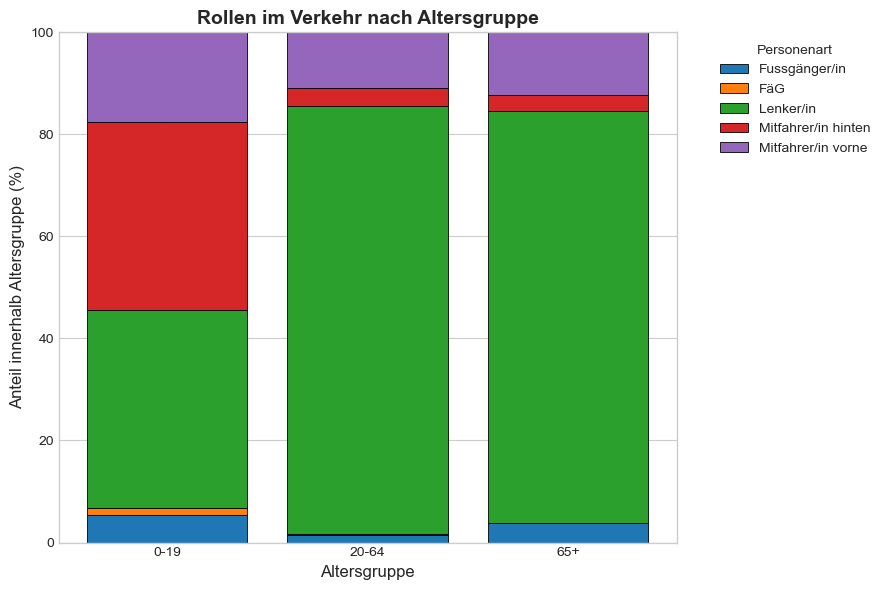


Rollen im Verkehr nach Altersgruppe (Prozentangaben):

0-19:
----------------------------------------------------------------------------------------------------
  Fussgänger/in                           :   5.37%
  FäG                                     :   1.42%
  Lenker/in                               :  38.70%
  Mitfahrer/in hinten                     :  36.88%
  Mitfahrer/in vorne                      :  17.63%
  Total                                   : 100.00%

20-64:
----------------------------------------------------------------------------------------------------
  Fussgänger/in                           :   1.53%
  FäG                                     :   0.08%
  Lenker/in                               :  83.97%
  Mitfahrer/in hinten                     :   3.52%
  Mitfahrer/in vorne                      :  10.89%
  Total                                   : 100.00%

65+:
--------------------------------------------------------------------------------------------------

In [13]:
# Keep only rows with known age_group and Personenart
df_roles = df_filt.dropna(subset=["age_group", "Personenart"])

# Compute counts by age_group and Personenart [person type]
role_counts = (
    df_roles
    .groupby(["age_group", "Personenart"])
    .size()
    .reset_index(name="count")
)

# Find top 5 roles overall to keep the plot readable
top_roles = (
    role_counts
    .groupby("Personenart")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(TOP_N_ROLES)
    .index
)

role_counts_top = role_counts[role_counts["Personenart"].isin(top_roles)]

# Convert to percentages within each age group
role_pct = (
    role_counts_top
    .groupby("age_group", group_keys=False)
    .apply(lambda g: g.assign(pct=g["count"] / g["count"].sum() * 100))
)

# Pivot for stacked bar plot
role_pivot = role_pct.pivot(index="age_group", columns="Personenart", values="pct").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

bottom = np.zeros(len(role_pivot))
x = np.arange(len(role_pivot.index))

for role in role_pivot.columns:
    values = role_pivot[role].values
    ax.bar(
        x,
        values,
        bottom=bottom,
        label=role,
        **PLOT_STYLE
    )
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(role_pivot.index)

ax.set_xlabel("Altersgruppe", fontsize=12)
ax.set_ylabel("Anteil innerhalb Altersgruppe (%)", fontsize=12)
ax.set_title("Rollen im Verkehr nach Altersgruppe", fontsize=14, fontweight="bold")

ax.legend(title="Personenart", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig("plots/rollen_im_verkehr_nach_altersgruppe.png", dpi=300, bbox_inches='tight')
plt.show()

# Print percentage values
print("\nRollen im Verkehr nach Altersgruppe (Prozentangaben):")
print("="*100)
for age_group in role_pivot.index:
    print(f"\n{age_group}:")
    print("-"*100)
    for role in role_pivot.columns:
        pct_value = role_pivot.loc[age_group, role]
        if pct_value > 0:  # Only print non-zero values
            print(f"  {role:40s}: {pct_value:6.2f}%")
    print(f"  {'Total':40s}: {role_pivot.loc[age_group].sum():6.2f}%")
print("="*100)

### 5.2 Unfalltypen: Senioren vs. Erwachsene

Vergleich der häufigsten Unfalltypen für Senioren (65+) gegenüber Erwachsenen (20-64). Dieses horizontale Balkendiagramm zeigt, welche Unfallszenarien bei älteren Verkehrsteilnehmern über- oder unterrepräsentiert sind.

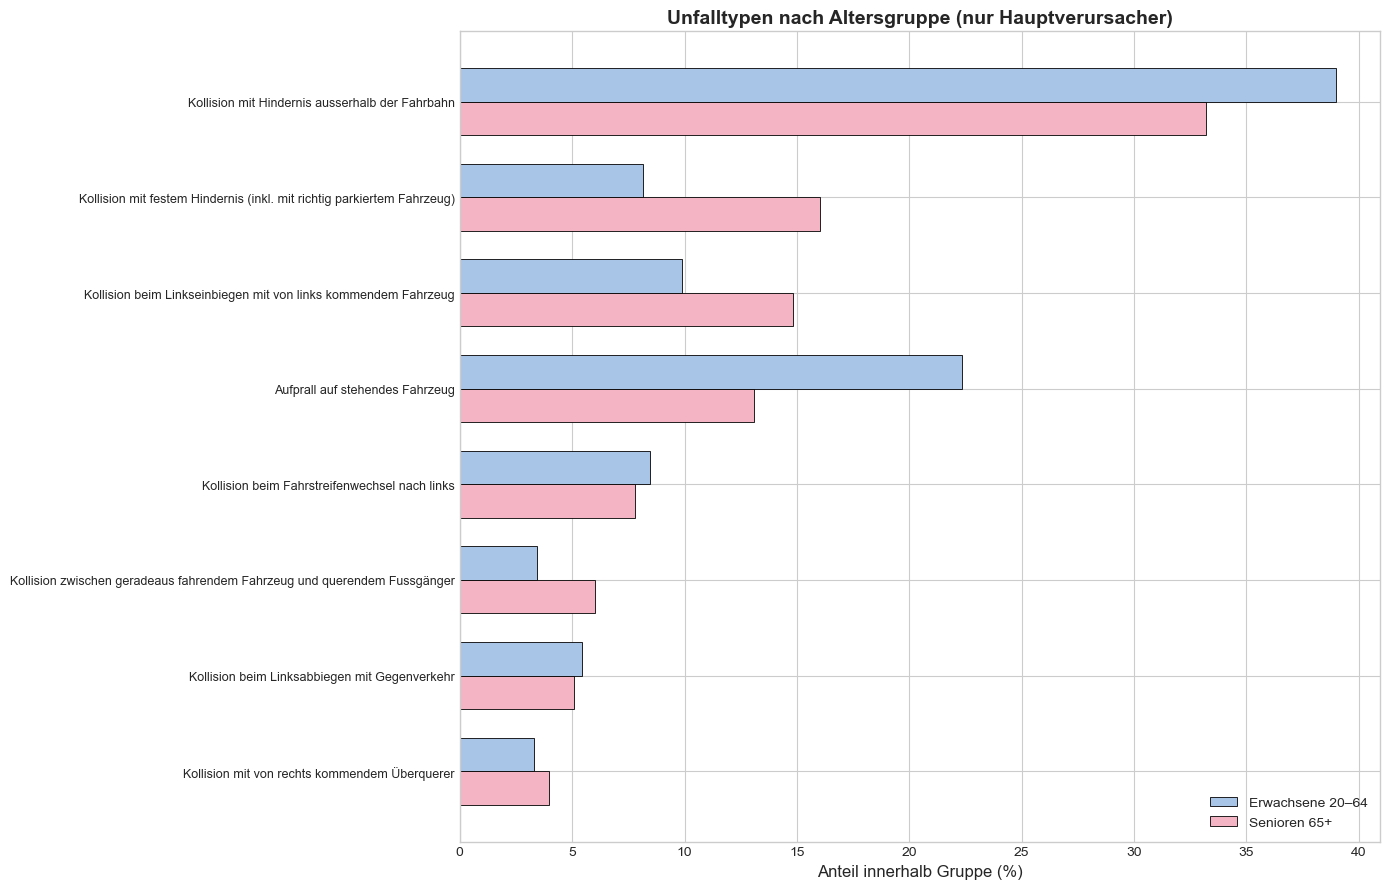


Nur Hauptverursacher
Total Senioren 65+ (Hauptverursacher): 84,724
Total Erwachsene 20-64 (Hauptverursacher): 427,062

Unfalltypengruppe → Unfalltyp (häufigster):
1. 0
   → Kollision mit Hindernis ausserhalb der Fahrbahn
   Senioren: 26,309 (33.2%) | Erwachsene: 152,142 (39.0%)

2. 7
   → Kollision mit festem Hindernis (inkl. mit richtig parkiertem Fahrzeug)
   Senioren: 12,706 (16.0%) | Erwachsene: 31,772 (8.1%)

3. 4
   → Kollision beim Linkseinbiegen mit von links kommendem Fahrzeug
   Senioren: 11,748 (14.8%) | Erwachsene: 38,604 (9.9%)

4. 2
   → Aufprall auf stehendes Fahrzeug
   Senioren: 10,365 (13.1%) | Erwachsene: 87,224 (22.4%)

5. 1
   → Kollision beim Fahrstreifenwechsel nach links
   Senioren: 6,186 (7.8%) | Erwachsene: 32,998 (8.5%)

6. 8
   → Kollision zwischen geradeaus fahrendem Fahrzeug und querendem Fussgänger
   Senioren: 4,758 (6.0%) | Erwachsene: 13,327 (3.4%)

7. 3
   → Kollision beim Linksabbiegen mit Gegenverkehr
   Senioren: 4,015 (5.1%) | Erwachsene: 21,224

In [14]:
# Filter data with valid age_group, Unfalltypengruppe, and Unfalltyp
# AND filter for Hauptverursacher (main responsible party)
df_types = df_filt.dropna(subset=["age_group", "Unfalltypengruppe", "Unfalltyp", "Hauptverursacher"])
df_types = df_types[df_types["Hauptverursacher"] == "ja"]

adults = df_types[df_types["age_group"] == "20-64"]
seniors = df_types[df_types["age_group"] == "65+"]

# Top 8 accident type groups for seniors based on Unfalltypengruppe
types_senior = seniors["Unfalltypengruppe"].value_counts().head(TOP_N_ACCIDENT_TYPES)
types_index = types_senior.index

senior_pct = types_senior / types_senior.sum() * 100

adult_counts = adults["Unfalltypengruppe"].value_counts().reindex(types_index, fill_value=0)
adult_pct = adult_counts / adult_counts.sum() * 100

# For each Unfalltypengruppe, get the most common Unfalltyp
type_labels = []
for type_gruppe in types_index:
    # Get most common Unfalltyp for this Unfalltypengruppe among seniors
    common_typ = seniors[seniors["Unfalltypengruppe"] == type_gruppe]["Unfalltyp"].mode()
    if len(common_typ) > 0:
        type_labels.append(common_typ.iloc[0])
    else:
        type_labels.append(str(type_gruppe))  # fallback to gruppe name

y = np.arange(len(types_index))

fig, ax = plt.subplots(figsize=(14, 9))

bar_height = 0.35

ax.barh(
    y - bar_height/2,
    adult_pct.values,
    height=bar_height,
    label="Erwachsene 20–64",
    color=COLOR_PALETTE['adults_20_64'],
    **PLOT_STYLE
)

ax.barh(
    y + bar_height/2,
    senior_pct.values,
    height=bar_height,
    label="Senioren 65+",
    color=COLOR_PALETTE['seniors_65plus'],
    **PLOT_STYLE
)

ax.set_yticks(y)
ax.set_yticklabels(type_labels, fontsize=9)

ax.set_xlabel("Anteil innerhalb Gruppe (%)", fontsize=12)
ax.set_title("Unfalltypen nach Altersgruppe (nur Hauptverursacher)", fontsize=14, fontweight="bold")

ax.legend()
ax.invert_yaxis()  # most frequent at top

plt.tight_layout()
plt.savefig("plots/unfalltypen_nach_altersgruppe.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed information
print("\nNur Hauptverursacher")
print(f"Total Senioren 65+ (Hauptverursacher): {len(seniors):,}")
print(f"Total Erwachsene 20-64 (Hauptverursacher): {len(adults):,}")
print("\nUnfalltypengruppe → Unfalltyp (häufigster):")
print("="*100)
for idx, (type_gruppe, type_label) in enumerate(zip(types_index, type_labels), start=1):
    count_seniors = types_senior[type_gruppe]
    count_adults = adult_counts[type_gruppe]
    pct_seniors = senior_pct[type_gruppe]
    pct_adults = adult_pct[type_gruppe]
    print(f"{idx}. {type_gruppe}")
    print(f"   → {type_label}")
    print(f"   Senioren: {count_seniors:,} ({pct_seniors:.1f}%) | Erwachsene: {count_adults:,} ({pct_adults:.1f}%)")
    print()
print("="*100)

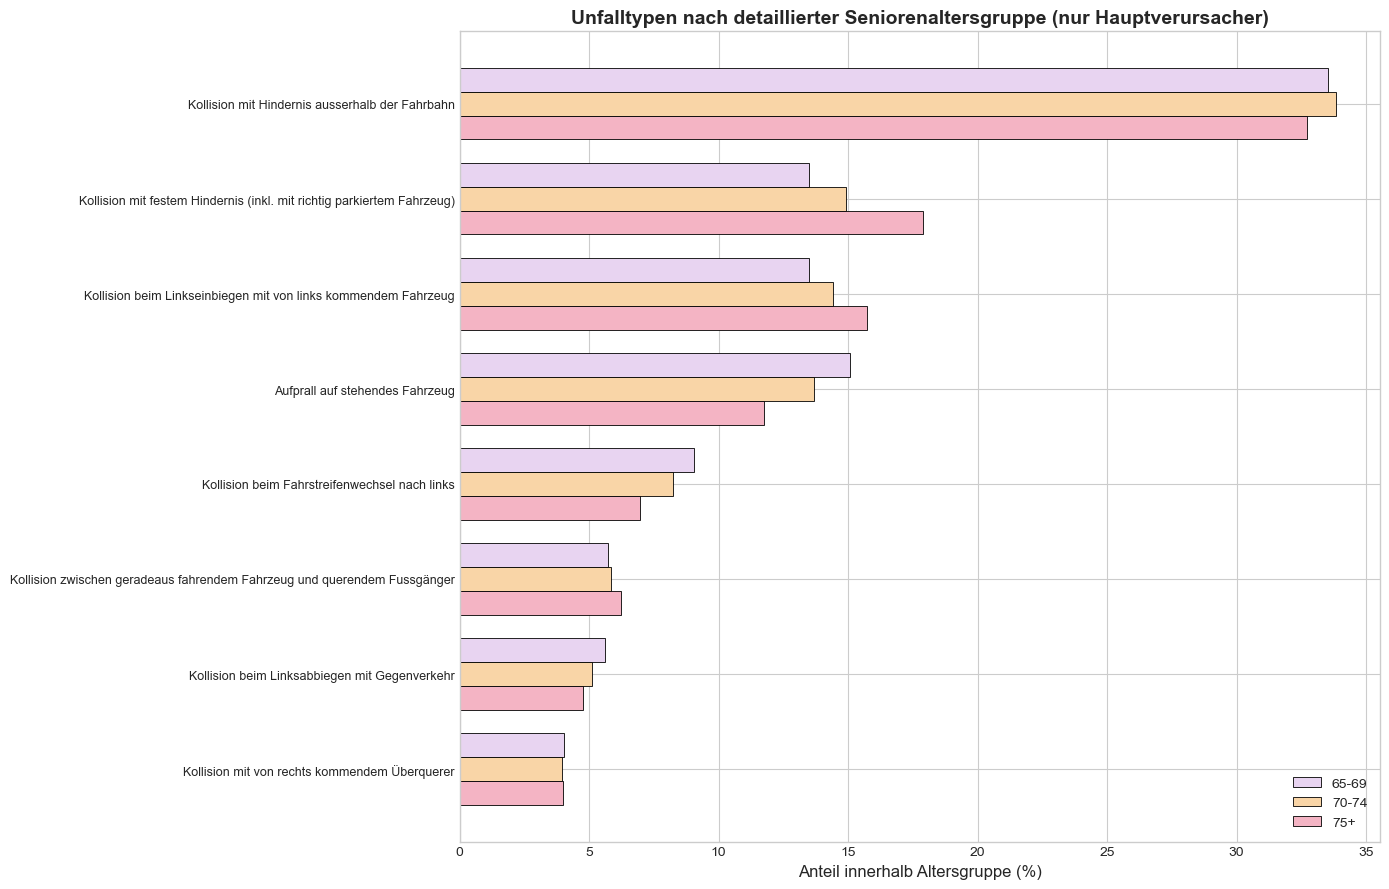


Nur Hauptverursacher
Total 65-69: 22,215
Total 70-74: 20,794
Total 75+: 41,711

Unfalltypengruppe → Unfalltyp (häufigster):
1. 0
   → Kollision mit Hindernis ausserhalb der Fahrbahn
   65-69: 6,865 (33.5%) | 70-74: 6,565 (33.8%) | 75+: 12,879 (32.7%)

2. 7
   → Kollision mit festem Hindernis (inkl. mit richtig parkiertem Fahrzeug)
   65-69: 2,765 (13.5%) | 70-74: 2,892 (14.9%) | 75+: 7,046 (17.9%)

3. 4
   → Kollision beim Linkseinbiegen mit von links kommendem Fahrzeug
   65-69: 2,765 (13.5%) | 70-74: 2,795 (14.4%) | 75+: 6,188 (15.7%)

4. 2
   → Aufprall auf stehendes Fahrzeug
   65-69: 3,085 (15.1%) | 70-74: 2,653 (13.7%) | 75+: 4,627 (11.8%)

5. 1
   → Kollision beim Fahrstreifenwechsel nach links
   65-69: 1,851 (9.0%) | 70-74: 1,596 (8.2%) | 75+: 2,738 (7.0%)

6. 8
   → Kollision zwischen geradeaus fahrendem Fahrzeug und querendem Fussgänger
   65-69: 1,175 (5.7%) | 70-74: 1,136 (5.9%) | 75+: 2,447 (6.2%)

7. 3
   → Kollision beim Linksabbiegen mit Gegenverkehr
   65-69: 1,151 (

In [15]:
# Unfalltypen by detailed senior age groups: 65-69, 70-74, 75+ (Hauptverursacher only)

# Filter for Hauptverursacher with valid data
df_types_senior = df_filt.dropna(subset=["Alter", "Unfalltypengruppe", "Unfalltyp", "Hauptverursacher"])
df_types_senior = df_types_senior[df_types_senior["Hauptverursacher"] == "ja"]

# Create detailed senior age groups
df_types_senior["senior_age_group"] = pd.cut(
    df_types_senior["Alter"],
    bins=[65, 70, 75, 120],
    labels=["65-69", "70-74", "75+"],
    right=False
)

# Filter for seniors only
df_types_senior = df_types_senior.dropna(subset=["senior_age_group"])

# Separate by age group
seniors_65_69 = df_types_senior[df_types_senior["senior_age_group"] == "65-69"]
seniors_70_74 = df_types_senior[df_types_senior["senior_age_group"] == "70-74"]
seniors_75_plus = df_types_senior[df_types_senior["senior_age_group"] == "75+"]

# Get top 8 accident types based on all seniors
all_seniors_types = df_types_senior["Unfalltypengruppe"].value_counts().head(TOP_N_ACCIDENT_TYPES)
types_index = all_seniors_types.index

# Calculate percentages for each age group
counts_65_69 = seniors_65_69["Unfalltypengruppe"].value_counts().reindex(types_index, fill_value=0)
pct_65_69 = counts_65_69 / counts_65_69.sum() * 100

counts_70_74 = seniors_70_74["Unfalltypengruppe"].value_counts().reindex(types_index, fill_value=0)
pct_70_74 = counts_70_74 / counts_70_74.sum() * 100

counts_75_plus = seniors_75_plus["Unfalltypengruppe"].value_counts().reindex(types_index, fill_value=0)
pct_75_plus = counts_75_plus / counts_75_plus.sum() * 100

# Get most common Unfalltyp for each type group
type_labels = []
for type_gruppe in types_index:
    common_typ = df_types_senior[df_types_senior["Unfalltypengruppe"] == type_gruppe]["Unfalltyp"].mode()
    if len(common_typ) > 0:
        type_labels.append(common_typ.iloc[0])
    else:
        type_labels.append(str(type_gruppe))

y = np.arange(len(types_index))

fig, ax = plt.subplots(figsize=(14, 9))

bar_height = 0.25

# Plot bars for each senior age group
ax.barh(
    y - bar_height,
    pct_65_69.values,
    height=bar_height,
    label="65-69",
    color=COLOR_PALETTE['age_65_69'],
    **PLOT_STYLE
)

ax.barh(
    y,
    pct_70_74.values,
    height=bar_height,
    label="70-74",
    color=COLOR_PALETTE['age_70_74'],
    **PLOT_STYLE
)

ax.barh(
    y + bar_height,
    pct_75_plus.values,
    height=bar_height,
    label="75+",
    color=COLOR_PALETTE['age_75plus'],
    **PLOT_STYLE
)

ax.set_yticks(y)
ax.set_yticklabels(type_labels, fontsize=9)

ax.set_xlabel("Anteil innerhalb Altersgruppe (%)", fontsize=12)
ax.set_title("Unfalltypen nach detaillierter Seniorenaltersgruppe (nur Hauptverursacher)", 
             fontsize=14, fontweight="bold")

ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("plots/unfalltypen_senioren_detailliert.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\nNur Hauptverursacher")
print(f"Total 65-69: {len(seniors_65_69):,}")
print(f"Total 70-74: {len(seniors_70_74):,}")
print(f"Total 75+: {len(seniors_75_plus):,}")
print("\nUnfalltypengruppe → Unfalltyp (häufigster):")
print("="*110)
for idx, (type_gruppe, type_label) in enumerate(zip(types_index, type_labels), start=1):
    print(f"{idx}. {type_gruppe}")
    print(f"   → {type_label}")
    print(f"   65-69: {counts_65_69[type_gruppe]:,} ({pct_65_69[type_gruppe]:.1f}%) | "
          f"70-74: {counts_70_74[type_gruppe]:,} ({pct_70_74[type_gruppe]:.1f}%) | "
          f"75+: {counts_75_plus[type_gruppe]:,} ({pct_75_plus[type_gruppe]:.1f}%)")
    print()
print("="*110)

Total Seniorenunfälle mit bekanntem Geschlecht: 128,738


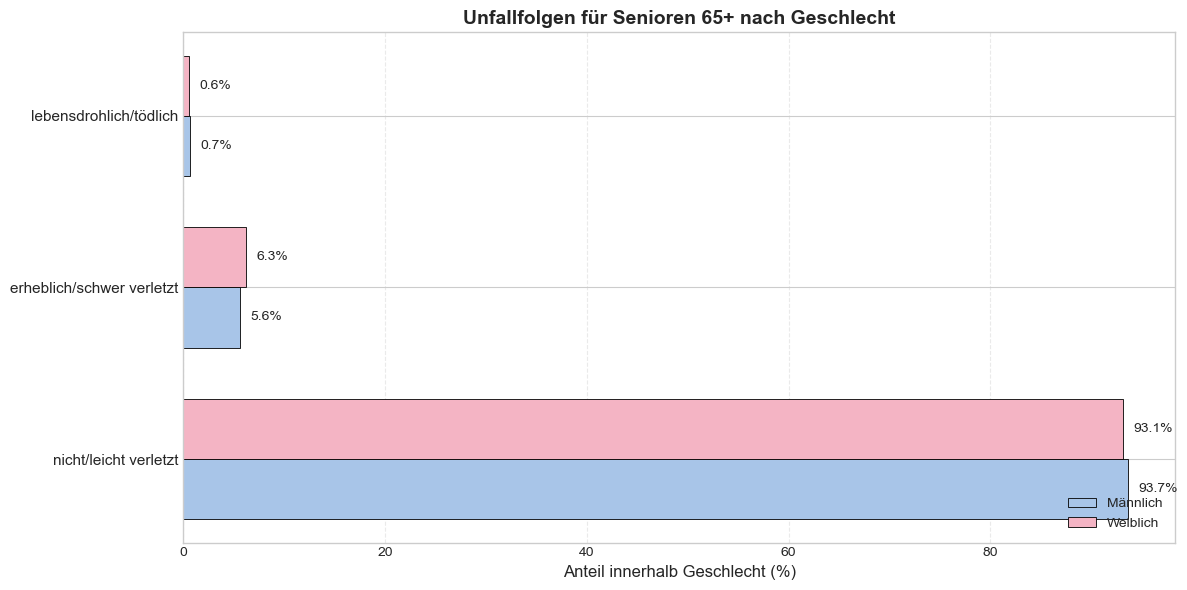


Unfallfolgen für Senioren 65+ nach Geschlecht:

Total: Männlich = 79,299 | Weiblich = 49,439

------------------------------------------------------------------------------------------

nicht / leicht verletzt / unbekannt:
   Männlich: 74,268 (93.7%)
   Weiblich: 46,051 (93.1%)
   Differenz: +0.5 Prozentpunkte

erheblich / schwer verletzt:
   Männlich: 4,479 (5.6%)
   Weiblich: 3,090 (6.3%)
   Differenz: -0.6 Prozentpunkte

lebensdrohlich / tödlich:
   Männlich: 552 (0.7%)
   Weiblich: 298 (0.6%)
   Differenz: +0.1 Prozentpunkte



In [16]:
# Accident severity (Unfallfolgen_Gruppen) for seniors 65+ by gender (male vs female)

# Gender values: 'Männlich' (male), 'Weiblich' (female)
male_label = "Männlich"
female_label = "Weiblich"

# Filter for seniors 65+ with valid severity and only male/female gender
df_senior_gender = df_filt[
    (df_filt["age_group"] == "65+") &
    (df_filt["Unfallfolgen_Gruppen"].notna()) &
    (df_filt["Geschlecht"].isin([male_label, female_label]))
].copy()

print(f"Total Seniorenunfälle mit bekanntem Geschlecht: {len(df_senior_gender):,}")

# Calculate counts and percentages by gender
gender_counts = df_senior_gender.groupby(["Unfallfolgen_Gruppen", "Geschlecht"]).size().unstack(fill_value=0)

# Order severity categories from least to most severe
severity_order = [
    "nicht / leicht verletzt / unbekannt",
    "erheblich / schwer verletzt", 
    "lebensdrohlich / tödlich"
]
gender_counts = gender_counts.reindex(severity_order)

# Calculate percentages within each gender
gender_pct = gender_counts.div(gender_counts.sum(axis=0), axis=1) * 100

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

y = np.arange(len(severity_order))
bar_height = 0.35

# Plot male bars (Männlich)
ax.barh(
    y - bar_height/2,
    gender_pct[male_label].values,
    height=bar_height,
    label=male_label,
    color=COLOR_PALETTE['male'],
    **PLOT_STYLE
)

# Plot female bars (Weiblich)
ax.barh(
    y + bar_height/2,
    gender_pct[female_label].values,
    height=bar_height,
    label=female_label,
    color=COLOR_PALETTE['female'],
    **PLOT_STYLE
)

# Simplified German labels for y-axis
severity_labels = [
    "nicht/leicht verletzt",
    "erheblich/schwer verletzt",
    "lebensdrohlich/tödlich"
]

ax.set_yticks(y)
ax.set_yticklabels(severity_labels, fontsize=11)
ax.set_xlabel("Anteil innerhalb Geschlecht (%)", fontsize=12)
ax.set_title("Unfallfolgen für Senioren 65+ nach Geschlecht", 
             fontsize=14, fontweight="bold")
ax.legend(loc='lower right')
ax.grid(True, axis="x", linestyle="--", alpha=0.4)

# Add value labels on bars
for i, (m_val, w_val) in enumerate(zip(gender_pct[male_label], gender_pct[female_label])):
    ax.text(m_val + 1, i - bar_height/2, f'{m_val:.1f}%', va='center', fontsize=10)
    ax.text(w_val + 1, i + bar_height/2, f'{w_val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig("plots/unfallfolgen_senioren_geschlecht.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\nUnfallfolgen für Senioren 65+ nach Geschlecht:")
print("="*90)
print(f"\nTotal: {male_label} = {gender_counts[male_label].sum():,} | {female_label} = {gender_counts[female_label].sum():,}")
print("\n" + "-"*90)
for severity in severity_order:
    m_count = gender_counts.loc[severity, male_label]
    w_count = gender_counts.loc[severity, female_label]
    m_pct = gender_pct.loc[severity, male_label]
    w_pct = gender_pct.loc[severity, female_label]
    print(f"\n{severity}:")
    print(f"   {male_label}: {m_count:,} ({m_pct:.1f}%)")
    print(f"   {female_label}: {w_count:,} ({w_pct:.1f}%)")
    print(f"   Differenz: {m_pct - w_pct:+.1f} Prozentpunkte")
print("\n" + "="*90)

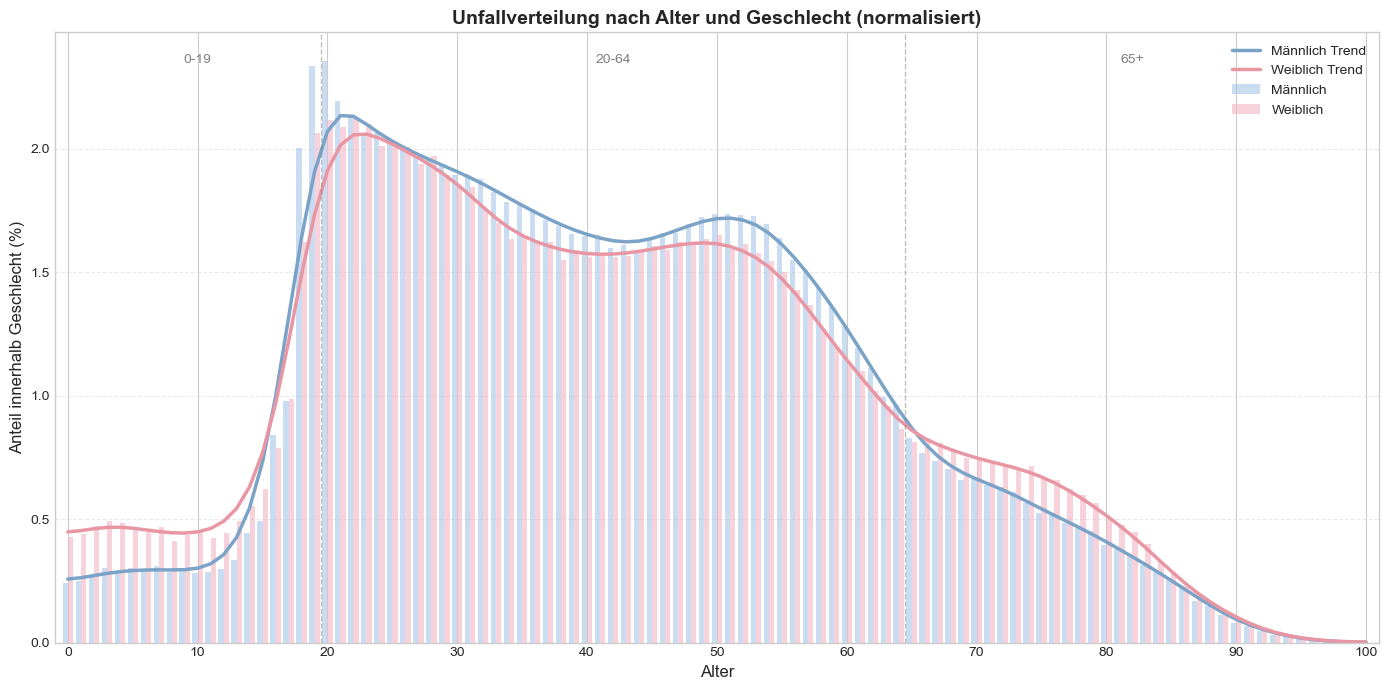


Unfallverteilung nach Alter und Geschlecht (normalisiert):

Gesamt: Männlich = 652,689 | Weiblich = 350,128
Verhältnis: 1.86 : 1 (Männlich:Weiblich)

Spitzenalter: Männlich = 20.0 Jahre (2.35%)
              Weiblich = 22.0 Jahre (2.12%)

Durchschnittsalter: Männlich = 41.3 Jahre | Weiblich = 41.1 Jahre

Normalisierungsprüfung: Männlich = 100.0% | Weiblich = 100.0%



In [17]:
# Distribution of accidents by exact age and gender (male vs female) - NORMALIZED
# With bar chart and smoothed trend curves (percentages within each gender)

from scipy.ndimage import gaussian_filter1d

male_label = "Männlich"
female_label = "Weiblich"

# Filter for valid gender (male/female only) and valid age
df_gender = df_filt[
    (df_filt["Geschlecht"].isin([male_label, female_label])) &
    (df_filt["Alter"].notna()) &
    (df_filt["Alter"] >= 0) &
    (df_filt["Alter"] <= 100)  # Reasonable age range
].copy()

# Count accidents by exact age and gender
gender_age_counts = df_gender.groupby(["Alter", "Geschlecht"]).size().unstack(fill_value=0)

# Ensure all ages from 0 to 100 are represented
all_ages = pd.DataFrame(index=range(0, 101))
gender_age_counts = all_ages.join(gender_age_counts).fillna(0)

# Get male and female counts
male_counts = gender_age_counts[male_label].values
female_counts = gender_age_counts[female_label].values
ages = gender_age_counts.index.values

# Normalize: convert to percentages within each gender
total_male = male_counts.sum()
total_female = female_counts.sum()
male_pct = (male_counts / total_male) * 100
female_pct = (female_counts / total_female) * 100

# Create smoothed curves using Gaussian filter on normalized data
male_smooth = gaussian_filter1d(male_pct.astype(float), sigma=2)
female_smooth = gaussian_filter1d(female_pct.astype(float), sigma=2)

# Create plot with bars and curves
fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.4

# Bar chart - male and female (normalized percentages)
bars_male = ax.bar(
    ages - bar_width/2,
    male_pct,
    width=bar_width,
    label=male_label,
    color=COLOR_PALETTE['male'],
    alpha=0.6,
    edgecolor='none'
)

bars_female = ax.bar(
    ages + bar_width/2,
    female_pct,
    width=bar_width,
    label=female_label,
    color=COLOR_PALETTE['female'],
    alpha=0.6,
    edgecolor='none'
)

# Smoothed trend curves on top (darker versions of the pastel colors for visibility)
ax.plot(ages, male_smooth, color='#7BA3C7', linewidth=2.5, label=f"{male_label} Trend")
ax.plot(ages, female_smooth, color='#E896A3', linewidth=2.5, label=f"{female_label} Trend")

# Add vertical lines to mark age group boundaries
ax.axvline(x=19.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=64.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(10, ax.get_ylim()[1]*0.95, '0-19', ha='center', fontsize=10, color='gray')
ax.text(42, ax.get_ylim()[1]*0.95, '20-64', ha='center', fontsize=10, color='gray')
ax.text(82, ax.get_ylim()[1]*0.95, '65+', ha='center', fontsize=10, color='gray')

# Labels and formatting
ax.set_xlabel("Alter", fontsize=12)
ax.set_ylabel("Anteil innerhalb Geschlecht (%)", fontsize=12)
ax.set_title("Unfallverteilung nach Alter und Geschlecht (normalisiert)", 
             fontsize=14, fontweight="bold")
ax.set_xlim(-1, 101)
ax.set_xticks(range(0, 101, 10))
ax.legend(loc='upper right')
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("plots/unfallverteilung_alter_geschlecht.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nUnfallverteilung nach Alter und Geschlecht (normalisiert):")
print("="*70)
print(f"\nGesamt: {male_label} = {total_male:,.0f} | {female_label} = {total_female:,.0f}")
print(f"Verhältnis: {total_male/total_female:.2f} : 1 (Männlich:Weiblich)\n")

# Find peak ages
male_peak_age = ages[np.argmax(male_pct)]
female_peak_age = ages[np.argmax(female_pct)]
male_peak_pct = male_pct.max()
female_peak_pct = female_pct.max()
print(f"Spitzenalter: {male_label} = {male_peak_age} Jahre ({male_peak_pct:.2f}%)")
print(f"              {female_label} = {female_peak_age} Jahre ({female_peak_pct:.2f}%)")

# Age statistics
male_mean_age = np.average(ages, weights=male_counts)
female_mean_age = np.average(ages, weights=female_counts)
print(f"\nDurchschnittsalter: {male_label} = {male_mean_age:.1f} Jahre | {female_label} = {female_mean_age:.1f} Jahre")

# Verify normalization
print(f"\nNormalisierungsprüfung: {male_label} = {male_pct.sum():.1f}% | {female_label} = {female_pct.sum():.1f}%")
print("\n" + "="*70)

### 5.3 Zeitliche Entwicklung: Senioren als Fussgänger und Velofahrende

Liniendiagramm, das zeigt, wie sich Unfälle mit Senioren als Fussgänger und Velofahrende von 2014 bis 2023 entwickelt haben. Vulnerable Verkehrsteilnehmer (Fussgänger und Velofahrende) haben ein höheres Verletzungsrisiko, weshalb zeitliche Trends für die Politikbewertung wichtig sind.

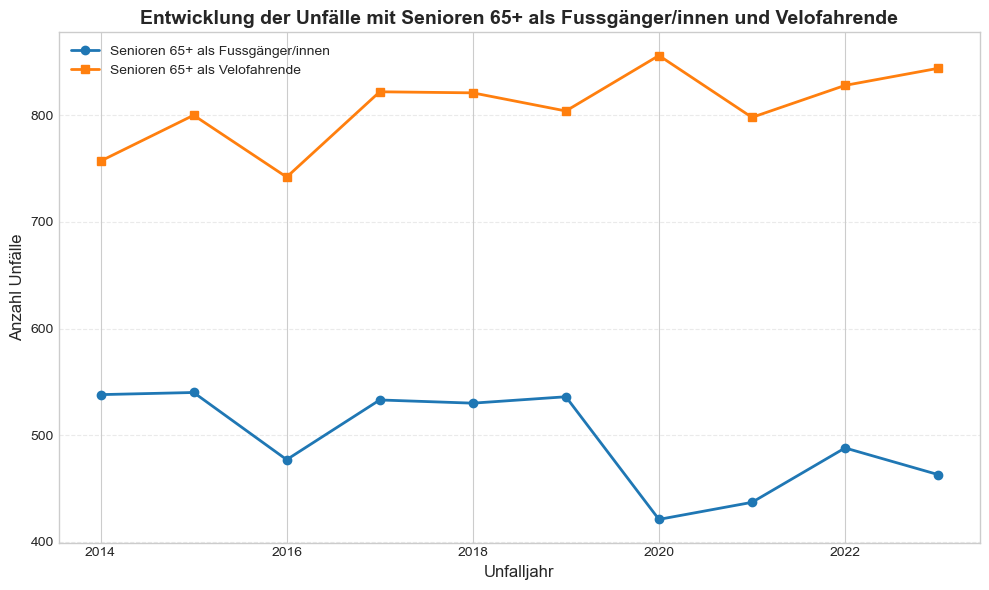

In [18]:
df_modes = df_filt.dropna(subset=["Unfalljahr", "Alter", "Verkehrsteilnahme"])

# Senioren 65+
df_modes_elder = filter_by_age_group(df_modes, min_age=SENIOR_AGE_THRESHOLD)

# Create a lowercased helper column
df_modes_elder["Verkehrsteilnahme_clean"] = df_modes_elder["Verkehrsteilnahme"].str.lower()

# Heuristic classification:
# Fussgänger/in
is_pedestrian = df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fuss", na=False) | \
                df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fuß", na=False)

# Velo/Fahrrad/Rad
is_cyclist = df_modes_elder["Verkehrsteilnahme_clean"].str.contains("velo", na=False) | \
             df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fahrrad", na=False) | \
             df_modes_elder["Verkehrsteilnahme_clean"].str.contains("rad", na=False)

df_ped = df_modes_elder[is_pedestrian]
df_cyc = df_modes_elder[is_cyclist]

# Count accidents per year
ped_counts = df_ped.groupby("Unfalljahr").size()
cyc_counts = df_cyc.groupby("Unfalljahr").size()

years_sorted = sorted(df_modes_elder["Unfalljahr"].dropna().unique())

# Align both series to the same years (fill missing with 0)
ped_counts = ped_counts.reindex(years_sorted, fill_value=0)
cyc_counts = cyc_counts.reindex(years_sorted, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    years_sorted,
    ped_counts.values,
    marker="o",
    linewidth=2,
    label="Senioren 65+ als Fussgänger/innen"
)

ax.plot(
    years_sorted,
    cyc_counts.values,
    marker="s",
    linewidth=2,
    label="Senioren 65+ als Velofahrende"
)

ax.set_xlabel("Unfalljahr", fontsize=12)
ax.set_ylabel("Anzahl Unfälle", fontsize=12)
ax.set_title("Entwicklung der Unfälle mit Senioren 65+ als Fussgänger/innen und Velofahrende", fontsize=14, fontweight="bold")

ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.savefig("plots/entwicklung_senioren_fussgaenger_velo.png", dpi=300, bbox_inches='tight')
plt.show()

### 5.4 Tageszeitliche Muster: Wann ereignen sich Unfälle?

Die stündliche Verteilung der Unfälle zeigt, ob Senioren andere Aktivitätsmuster haben als Erwachsene. Spitzenunfallzeiten können Pendelmuster, Besorgungsfahrten oder Sichtbarkeitsprobleme widerspiegeln.

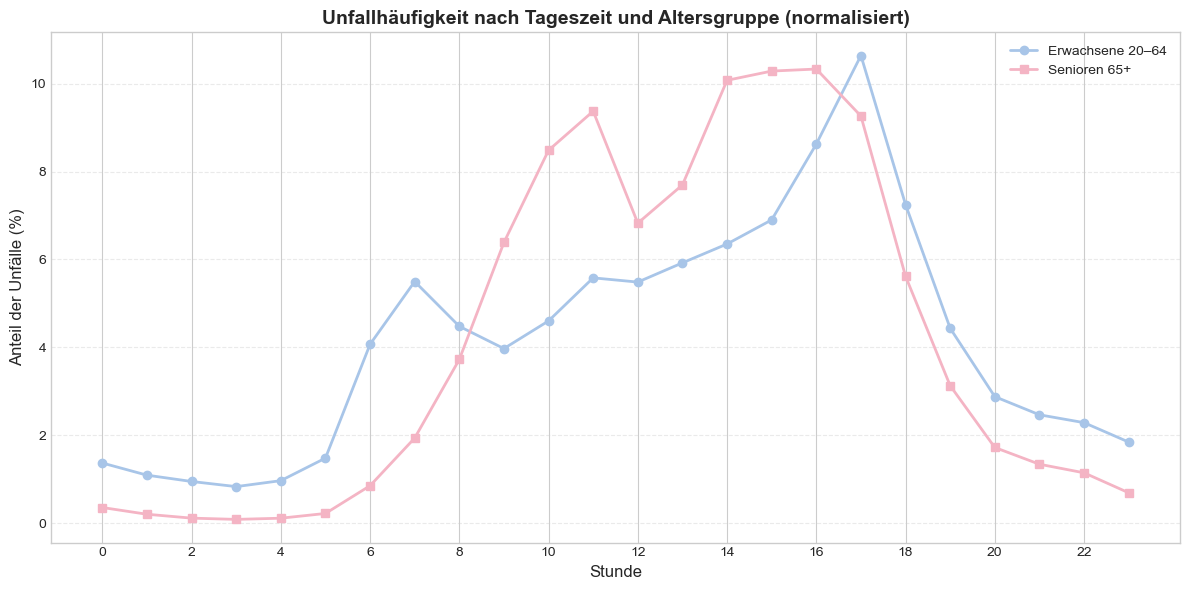


Zusammenfassung - Normalisiert:
  Erwachsene 20-64: Spitzenstunde = 17:00 mit 10.6% der Unfälle
  Senioren 65+: Spitzenstunde = 16:00 mit 10.3% der Unfälle

  Total Erwachsene: 755,760 | Total Senioren: 129,162


In [19]:
# Filter data with valid hour and age group
df_time = df_filt.dropna(subset=["Stunde", "age_group"])

# Separate adults and seniors
df_adults_time = df_time[df_time["age_group"] == "20-64"]
df_seniors_time = df_time[df_time["age_group"] == "65+"]

# Count accidents by hour for each group
adults_by_hour = df_adults_time.groupby("Stunde").size()
seniors_by_hour = df_seniors_time.groupby("Stunde").size()

# Ensure all hours 0-23 are represented
all_hours = range(24)
adults_by_hour = adults_by_hour.reindex(all_hours, fill_value=0)
seniors_by_hour = seniors_by_hour.reindex(all_hours, fill_value=0)

# Normalize to percentages (each group sums to 100%)
adults_pct = adults_by_hour / adults_by_hour.sum() * 100
seniors_pct = seniors_by_hour / seniors_by_hour.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    all_hours,
    adults_pct.values,
    marker='o',
    linewidth=2,
    label="Erwachsene 20–64",
    color=COLOR_PALETTE['adults_20_64']
)

ax.plot(
    all_hours,
    seniors_pct.values,
    marker='s',
    linewidth=2,
    label="Senioren 65+",
    color=COLOR_PALETTE['seniors_65plus']
)

ax.set_xlabel("Stunde", fontsize=12)
ax.set_ylabel("Anteil der Unfälle (%)", fontsize=12)
ax.set_title("Unfallhäufigkeit nach Tageszeit und Altersgruppe (normalisiert)", fontsize=14, fontweight="bold")

ax.set_xticks(range(0, 24, 2))
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.savefig("plots/unfallhaeufigkeit_tageszeit.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nZusammenfassung - Normalisiert:")
print(f"  Erwachsene 20-64: Spitzenstunde = {adults_pct.idxmax():.0f}:00 mit {adults_pct.max():.1f}% der Unfälle")
print(f"  Senioren 65+: Spitzenstunde = {seniors_pct.idxmax():.0f}:00 mit {seniors_pct.max():.1f}% der Unfälle")
print(f"\n  Total Erwachsene: {adults_by_hour.sum():,} | Total Senioren: {seniors_by_hour.sum():,}")

### 5.5 Tageszeit bei schweren/tödlichen Unfällen (Senioren als Lenker)

Fokus nur auf schwere und tödliche Unfälle mit Senioren als Lenker. Diese Grafik identifiziert die gefährlichsten Stunden. Unterschiedliche Zeitmuster können auf spezifische Risikofaktoren hinweisen (z.B. Berufsverkehr, schlechte Lichtverhältnisse).

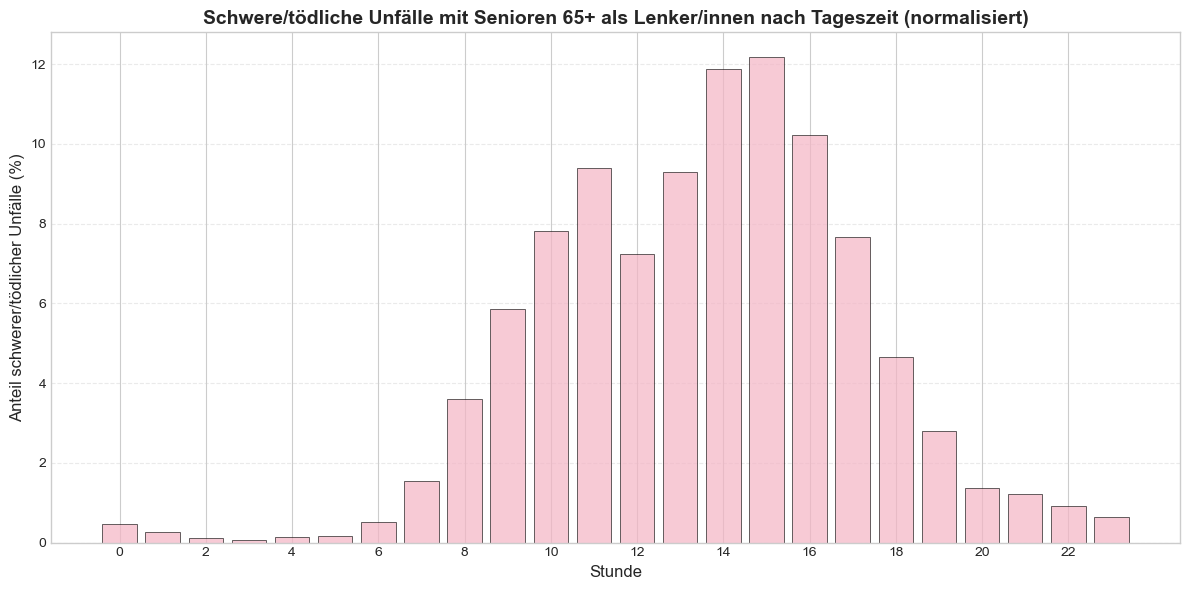


Total schwere/tödliche Unfälle mit Senioren als Lenker: 5,653
Spitzenstunde: 15:00 mit 12.2% der Unfälle


In [20]:
# Filter for severe/fatal accidents with senior drivers
df_severe_time = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Personenart"] == "Lenker/in") &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD) &
    (df_filt["Stunde"].notna())
].copy()

# Count by hour
severe_by_hour = df_severe_time.groupby("Stunde").size()
severe_by_hour = severe_by_hour.reindex(range(24), fill_value=0)

# Normalize to percentages
severe_pct = severe_by_hour / severe_by_hour.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    range(24),
    severe_pct.values,
    color=COLOR_PALETTE['seniors_65plus'],
    alpha=0.7,
    **PLOT_STYLE
)

ax.set_xlabel("Stunde", fontsize=12)
ax.set_ylabel("Anteil schwerer/tödlicher Unfälle (%)", fontsize=12)
ax.set_title("Schwere/tödliche Unfälle mit Senioren 65+ als Lenker/innen nach Tageszeit (normalisiert)", fontsize=14, fontweight="bold")

ax.set_xticks(range(0, 24, 2))
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("plots/schwere_unfaelle_senioren_tageszeit.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal schwere/tödliche Unfälle mit Senioren als Lenker: {severe_by_hour.sum():,}")
print(f"Spitzenstunde: {severe_pct.idxmax():.0f}:00 mit {severe_pct.max():.1f}% der Unfälle")

## 6. Umwelt- und Kontextfaktoren

Untersuchung, wie Umweltbedingungen (innerorts/ausserorts, Witterung, Strassenzustand, Beleuchtung) mit der Unfallschwere bei älteren Verkehrsteilnehmern interagieren.

### 6.1 Unfallschwere nach innerorts/ausserorts

Vergleich der Verletzungsschwereverteilung für Senioren gegenüber Erwachsenen in innerorts und ausserorts Gebieten. Ausserorts-Unfälle können aufgrund höherer Geschwindigkeiten schwerer sein, während innerorts-Unfälle häufiger auftreten können.

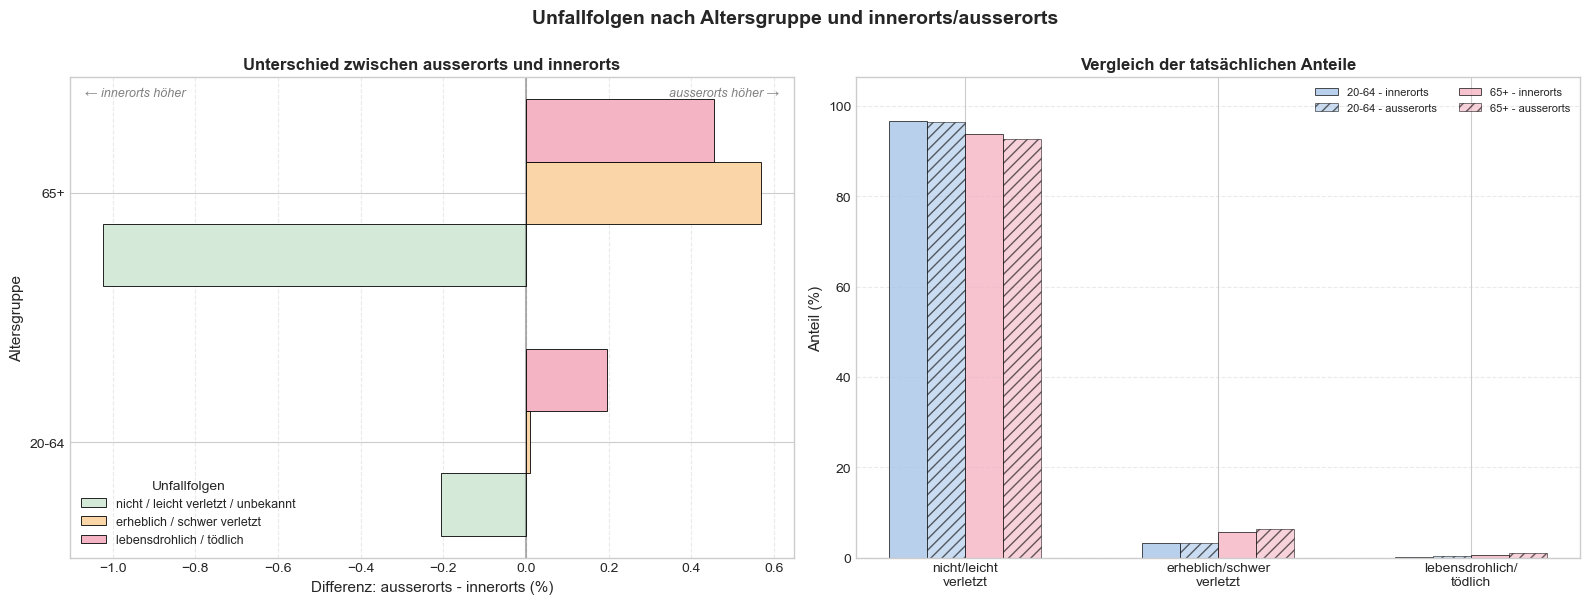


Unfallfolgen nach Altersgruppe und Ort:
Unfallfolgen_Gruppen           erheblich / schwer verletzt  \
age_group InnerortsAusserorts                                
20-64     ausserorts                                   3.3   
          innerorts                                    3.3   
65+       ausserorts                                   6.3   
          innerorts                                    5.7   

Unfallfolgen_Gruppen           lebensdrohlich / tödlich  \
age_group InnerortsAusserorts                             
20-64     ausserorts                                0.3   
          innerorts                                 0.1   
65+       ausserorts                                1.0   
          innerorts                                 0.5   

Unfallfolgen_Gruppen           nicht / leicht verletzt / unbekannt  
age_group InnerortsAusserorts                                       
20-64     ausserorts                                          96.4  
          innerorts     

In [21]:
# Filter data with valid severity, location, and age group
df_env = df_filt.dropna(subset=["Unfallfolgen_Gruppen", "InnerortsAusserorts", "age_group"])

# Focus on adults and seniors
df_env = df_env[df_env["age_group"].isin(["20-64", "65+"])]

# Create crosstab for each location type
severity_by_group_location = pd.crosstab(
    [df_env["age_group"], df_env["InnerortsAusserorts"]],
    df_env["Unfallfolgen_Gruppen"],
    normalize='index'
) * 100

# Restructure data to calculate urban-rural differences
# Get separate dataframes for urban and rural
urban_data = {}
rural_data = {}

for age_group in ["20-64", "65+"]:
    if (age_group, "innerorts") in severity_by_group_location.index:
        urban_data[age_group] = severity_by_group_location.loc[(age_group, "innerorts")]
    if (age_group, "ausserorts") in severity_by_group_location.index:
        rural_data[age_group] = severity_by_group_location.loc[(age_group, "ausserorts")]

# Calculate differences (Rural - Urban) for each severity and age group
differences = {}
for age_group in ["20-64", "65+"]:
    if age_group in urban_data and age_group in rural_data:
        differences[age_group] = rural_data[age_group] - urban_data[age_group]

# Convert to DataFrame for plotting
diff_df = pd.DataFrame(differences).T

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Diverging bar chart showing differences
severity_order = ["nicht / leicht verletzt / unbekannt", 
                  "erheblich / schwer verletzt", 
                  "lebensdrohlich / tödlich"]
colors_diff = [COLOR_PALETTE['not_injured'], COLOR_PALETTE['severe'], COLOR_PALETTE['fatal']]

x = np.arange(len(diff_df.index))
width = 0.25

for idx, severity in enumerate(severity_order):
    if severity in diff_df.columns:
        values = diff_df[severity].values
        ax1.barh(
            x + idx * width - width,
            values,
            height=width,
            label=severity,
            color=colors_diff[idx],
            edgecolor='black',
            linewidth=0.6
        )

ax1.axvline(x=0, color='black', linewidth=1.5, linestyle='-', alpha=0.3)
ax1.set_yticks(x)
ax1.set_yticklabels(diff_df.index)
ax1.set_xlabel("Differenz: ausserorts - innerorts (%)", fontsize=11)
ax1.set_ylabel("Altersgruppe", fontsize=11)
ax1.set_title("Unterschied zwischen ausserorts und innerorts", 
              fontsize=12, fontweight="bold")
ax1.legend(title="Unfallfolgen", loc='best', fontsize=9)
ax1.grid(True, axis="x", linestyle="--", alpha=0.4)

# Add annotations for interpretation
ax1.text(0.02, 0.98, "← innerorts höher", 
         transform=ax1.transAxes, fontsize=9, va='top', ha='left', style='italic', color='gray')
ax1.text(0.98, 0.98, "ausserorts höher →", 
         transform=ax1.transAxes, fontsize=9, va='top', ha='right', style='italic', color='gray')

# Right plot: Grouped comparison of actual percentages
x2 = np.arange(len(severity_order))
width2 = 0.15
age_groups = ["20-64", "65+"]
locations = ["innerorts", "ausserorts"]

bar_positions = []
bar_colors = [COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']]
patterns = ['', '///']  # solid for urban, hatched for rural

offset = 0
for age_idx, age_group in enumerate(age_groups):
    for loc_idx, location in enumerate(locations):
        if (age_group, location) in severity_by_group_location.index:
            values = [severity_by_group_location.loc[(age_group, location), sev] 
                     if sev in severity_by_group_location.columns else 0 
                     for sev in severity_order]
            
            pos = x2 + offset
            bars = ax2.bar(
                pos,
                values,
                width=width2,
                label=f"{age_group} - {location}",
                color=bar_colors[age_idx],
                alpha=0.8 if location == "innerorts" else 0.6,
                edgecolor='black',
                linewidth=0.6,
                hatch=patterns[loc_idx]
            )
            offset += width2

ax2.set_xticks(x2 + width2 * 1.5)
ax2.set_xticklabels(['nicht/leicht\nverletzt', 'erheblich/schwer\nverletzt', 'lebensdrohlich/\ntödlich'], 
                     fontsize=10)
ax2.set_ylabel("Anteil (%)", fontsize=11)
ax2.set_title("Vergleich der tatsächlichen Anteile", 
              fontsize=12, fontweight="bold")
ax2.legend(loc='upper right', fontsize=8, ncol=2)
ax2.grid(True, axis="y", linestyle="--", alpha=0.4)
ax2.set_ylim(0, max(severity_by_group_location.max()) * 1.1)

plt.suptitle("Unfallfolgen nach Altersgruppe und innerorts/ausserorts", 
             fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.savefig("plots/unfallfolgen_innerorts_ausserorts.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary table with differences
print("\nUnfallfolgen nach Altersgruppe und Ort:")
print("="*90)
print(severity_by_group_location.round(1))
print("\n" + "="*90)
print("\nDifferenzen (ausserorts - innerorts):")
print("="*90)
print(diff_df.round(1))
print("="*90)
print("\nInterpretation:")
print("  Positive Werte: ausserorts höher")
print("  Negative Werte: innerorts höher")

### 6.2 Schwere/tödliche Unfälle nach Witterung und Strassenzustand (Senioren 65+)

Für Senioren wird untersucht, wie Witterung und Strassenzustand bei schweren und tödlichen Unfällen verteilt sind. Ungünstige Bedingungen können ältere Fahrer unverhältnismässig stark beeinflussen.

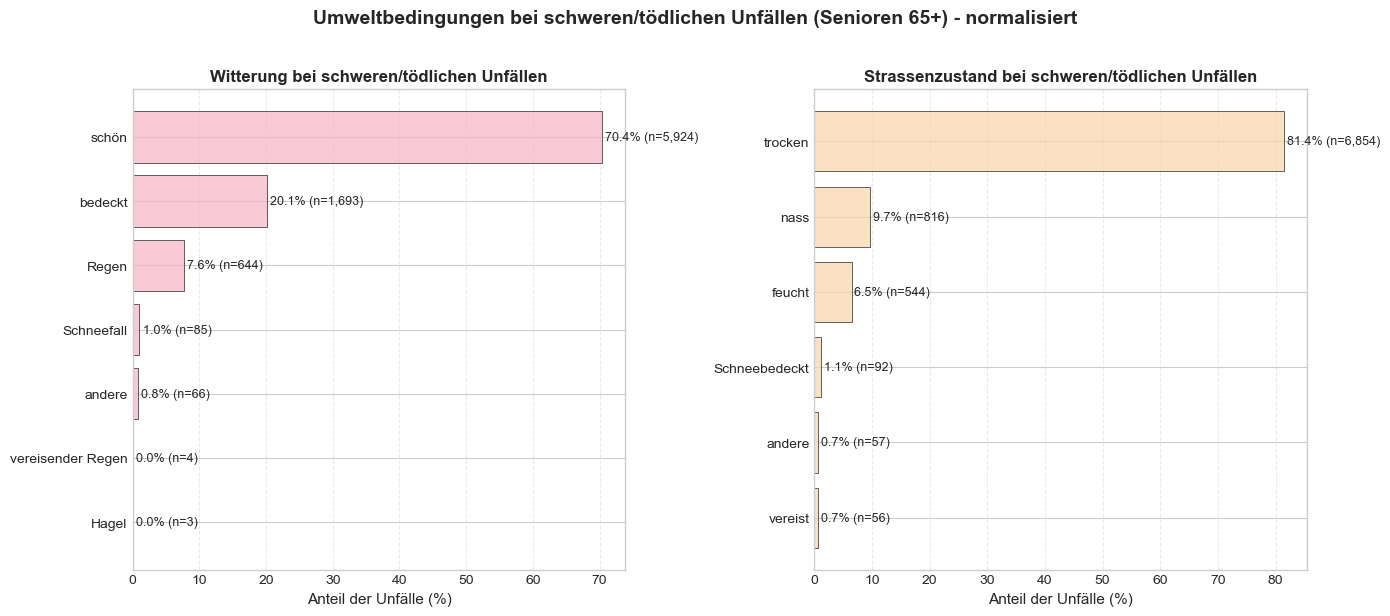


Total schwere/tödliche Unfälle mit Senioren 65+: 8,419


In [22]:
# Filter for severe/fatal accidents with seniors
df_severe_env = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD)
].copy()

# Weather conditions - normalized
weather_counts = df_severe_env["Witterung"].value_counts().head(8)
weather_pct = weather_counts / weather_counts.sum() * 100

# Road conditions - normalized
road_counts = df_severe_env["Strassenzustand"].value_counts().head(8)
road_pct = road_counts / road_counts.sum() * 100

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Weather plot
ax1.barh(
    range(len(weather_pct)),
    weather_pct.values,
    color=COLOR_PALETTE['seniors_65plus'],
    alpha=0.7,
    **PLOT_STYLE
)
ax1.set_yticks(range(len(weather_pct)))
ax1.set_yticklabels(weather_pct.index, fontsize=10)
ax1.set_xlabel("Anteil der Unfälle (%)", fontsize=11)
ax1.set_title("Witterung bei schweren/tödlichen Unfällen", fontsize=12, fontweight="bold")
ax1.invert_yaxis()
ax1.grid(True, axis="x", linestyle="--", alpha=0.4)

# Add value labels
for i, (v, c) in enumerate(zip(weather_pct.values, weather_counts.values)):
    ax1.text(v + 0.5, i, f'{v:.1f}% (n={c:,})', va='center', fontsize=9)

# Road condition plot
ax2.barh(
    range(len(road_pct)),
    road_pct.values,
    color=COLOR_PALETTE['age_70_74'],
    alpha=0.7,
    **PLOT_STYLE
)
ax2.set_yticks(range(len(road_pct)))
ax2.set_yticklabels(road_pct.index, fontsize=10)
ax2.set_xlabel("Anteil der Unfälle (%)", fontsize=11)
ax2.set_title("Strassenzustand bei schweren/tödlichen Unfällen", fontsize=12, fontweight="bold")
ax2.invert_yaxis()
ax2.grid(True, axis="x", linestyle="--", alpha=0.4)

# Add value labels
for i, (v, c) in enumerate(zip(road_pct.values, road_counts.values)):
    ax2.text(v + 0.5, i, f'{v:.1f}% (n={c:,})', va='center', fontsize=9)

plt.suptitle("Umweltbedingungen bei schweren/tödlichen Unfällen (Senioren 65+) - normalisiert", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("plots/umweltbedingungen_senioren.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal schwere/tödliche Unfälle mit Senioren 65+: {len(df_severe_env):,}")

### 6.2b Umweltbedingungen: Vergleich nach Altersgruppen

Vergleich, wie Witterung und Strassenzustand schwere/tödliche Unfälle über alle Altersgruppen hinweg beeinflussen. Dies zeigt, ob ungünstige Umweltbedingungen einen unverhältnismässigen Einfluss auf jüngere vs. ältere Verkehrsteilnehmer haben.

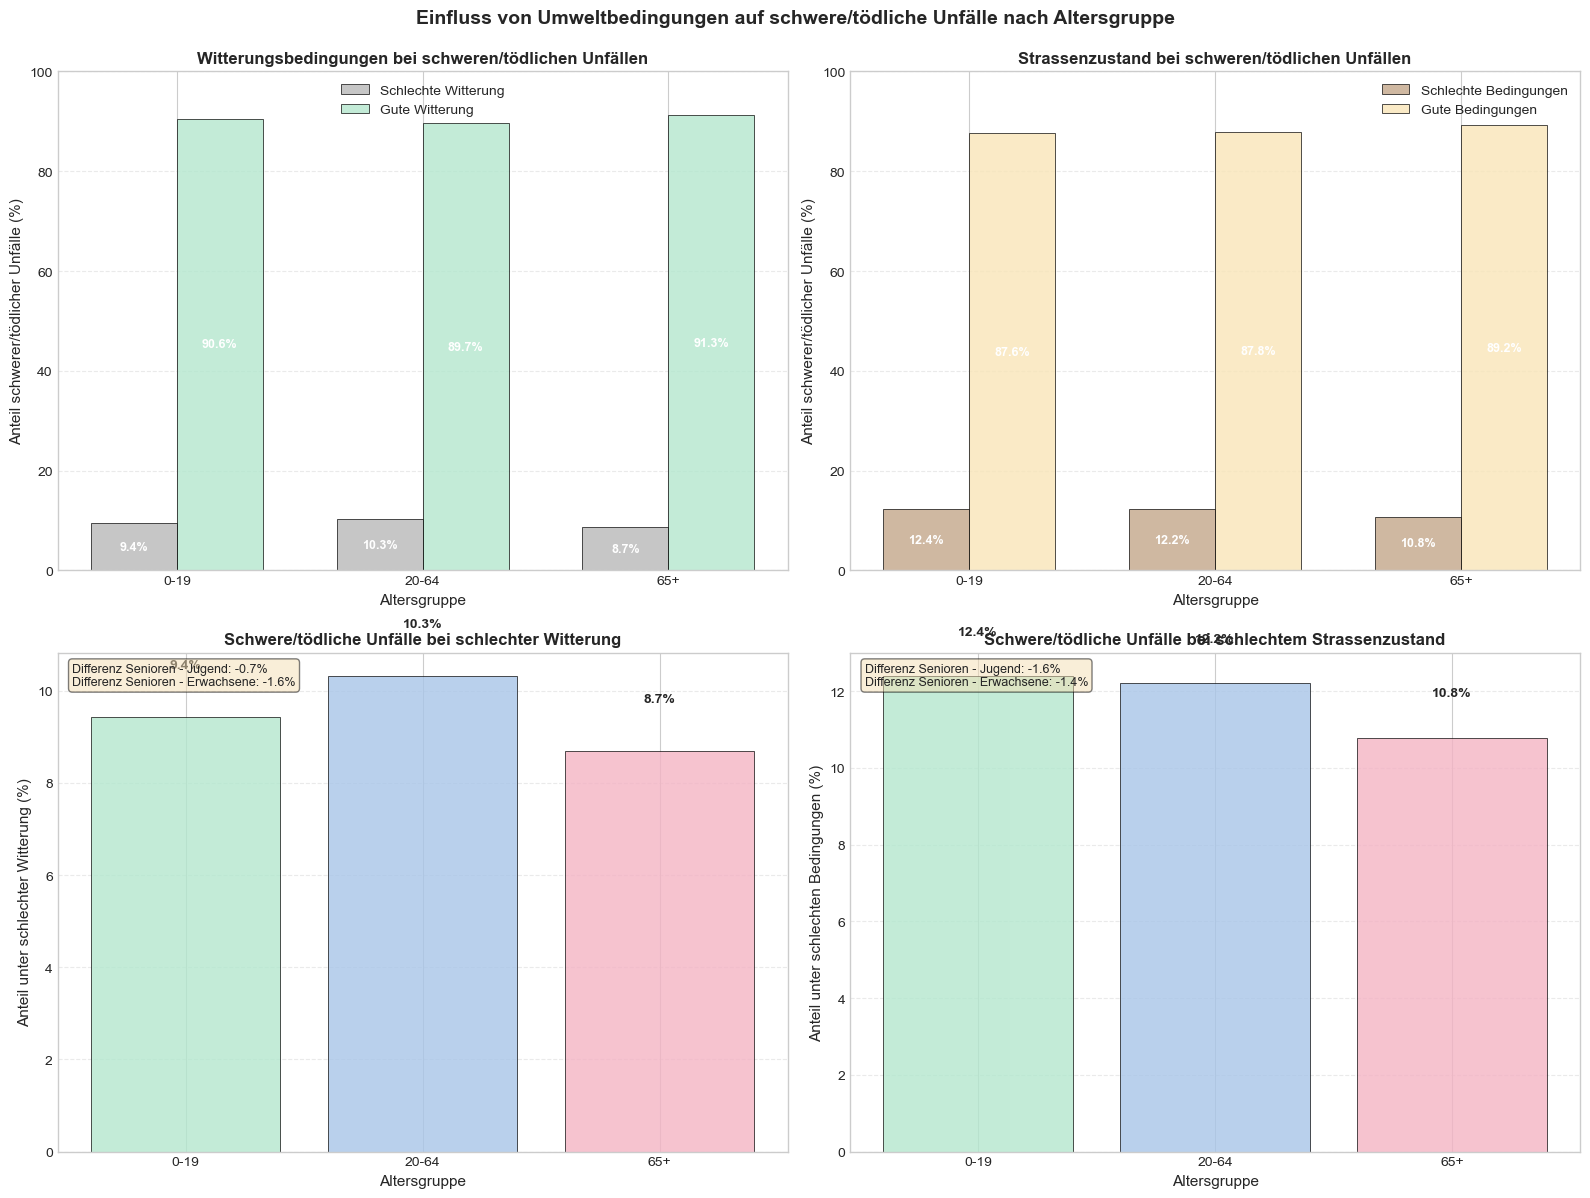


WITTERUNGSBEDINGUNGEN

0-19:
  Total schwere/tödliche Unfälle: 4,917
  Schlechte Witterung: 9.4%
  Gute Witterung: 90.6%

20-64:
  Total schwere/tödliche Unfälle: 25,918
  Schlechte Witterung: 10.3%
  Gute Witterung: 89.7%

65+:
  Total schwere/tödliche Unfälle: 8,419
  Schlechte Witterung: 8.7%
  Gute Witterung: 91.3%

STRASSENZUSTAND

0-19:
  Total schwere/tödliche Unfälle: 4,917
  Schlechte Bedingungen: 12.4%
  Gute Bedingungen: 87.6%

20-64:
  Total schwere/tödliche Unfälle: 25,918
  Schlechte Bedingungen: 12.2%
  Gute Bedingungen: 87.8%

65+:
  Total schwere/tödliche Unfälle: 8,419
  Schlechte Bedingungen: 10.8%
  Gute Bedingungen: 89.2%

INTERPRETATION
Witterung - Senioren vs. Jugend: -0.7 Prozentpunkte
Witterung - Senioren vs. Erwachsene: -1.6 Prozentpunkte
Strassenzustand - Senioren vs. Jugend: -1.6 Prozentpunkte
Strassenzustand - Senioren vs. Erwachsene: -1.4 Prozentpunkte

Positive Werte = höherer Anteil bei Senioren
Negative Werte = höherer Anteil bei jüngeren Gruppen


In [23]:
# Filter for severe/fatal accidents across all age groups
df_env_age_compare = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["age_group"].notna())
].copy()

# Define adverse conditions
adverse_weather = ["Regen", "Schneefall", "Hagel", "Nebel"]
adverse_road = ["nass", "Schnee", "Eis, Frost", "verschmutzt"]

# Calculate percentage of severe/fatal accidents under adverse conditions by age group
weather_analysis = []
road_analysis = []

for age_group in AGE_LABELS:
    df_age = df_env_age_compare[df_env_age_compare["age_group"] == age_group]
    total = len(df_age)
    
    if total > 0:
        # Weather analysis
        adverse_weather_count = df_age[df_age["Witterung"].isin(adverse_weather)].shape[0]
        weather_pct = (adverse_weather_count / total) * 100
        weather_analysis.append({
            'age_group': age_group,
            'adverse_pct': weather_pct,
            'good_pct': 100 - weather_pct,
            'total': total
        })
        
        # Road condition analysis
        adverse_road_count = df_age[df_age["Strassenzustand"].str.contains('|'.join(adverse_road), case=False, na=False)].shape[0]
        road_pct = (adverse_road_count / total) * 100
        road_analysis.append({
            'age_group': age_group,
            'adverse_pct': road_pct,
            'good_pct': 100 - road_pct,
            'total': total
        })

weather_df = pd.DataFrame(weather_analysis)
road_df = pd.DataFrame(road_analysis)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Weather conditions comparison
ax1 = axes[0, 0]
x = np.arange(len(weather_df))
width = 0.35

bars1 = ax1.bar(x - width/2, weather_df['adverse_pct'], width, 
                label='Schlechte Witterung',
                color=COLOR_PALETTE['bad_weather'], alpha=0.8, **PLOT_STYLE)
bars2 = ax1.bar(x + width/2, weather_df['good_pct'], width,
                label='Gute Witterung',
                color=COLOR_PALETTE['good_weather'], alpha=0.8, **PLOT_STYLE)

ax1.set_xlabel("Altersgruppe", fontsize=11)
ax1.set_ylabel("Anteil schwerer/tödlicher Unfälle (%)", fontsize=11)
ax1.set_title("Witterungsbedingungen bei schweren/tödlichen Unfällen", 
              fontsize=12, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(weather_df['age_group'])
ax1.legend()
ax1.grid(True, axis="y", linestyle="--", alpha=0.4)
ax1.set_ylim(0, 100)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 3:  # Only show if bar is visible enough
            ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Top right: Road conditions comparison
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, road_df['adverse_pct'], width,
                label='Schlechte Bedingungen',
                color=COLOR_PALETTE['bad_road'], alpha=0.8, **PLOT_STYLE)
bars4 = ax2.bar(x + width/2, road_df['good_pct'], width,
                label='Gute Bedingungen',
                color=COLOR_PALETTE['good_road'], alpha=0.8, **PLOT_STYLE)

ax2.set_xlabel("Altersgruppe", fontsize=11)
ax2.set_ylabel("Anteil schwerer/tödlicher Unfälle (%)", fontsize=11)
ax2.set_title("Strassenzustand bei schweren/tödlichen Unfällen",
              fontsize=12, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(road_df['age_group'])
ax2.legend()
ax2.grid(True, axis="y", linestyle="--", alpha=0.4)
ax2.set_ylim(0, 100)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 3:
            ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Bottom left: Adverse weather only - direct comparison
ax3 = axes[1, 0]
bars5 = ax3.bar(x, weather_df['adverse_pct'], 
                color=[COLOR_PALETTE['youth_0_19'], COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
                alpha=0.8, **PLOT_STYLE)

ax3.set_xlabel("Altersgruppe", fontsize=11)
ax3.set_ylabel("Anteil unter schlechter Witterung (%)", fontsize=11)
ax3.set_title("Schwere/tödliche Unfälle bei schlechter Witterung",
              fontsize=12, fontweight="bold")
ax3.set_xticks(x)
ax3.set_xticklabels(weather_df['age_group'])
ax3.grid(True, axis="y", linestyle="--", alpha=0.4)

# Add value labels and highlight differences
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate and display relative differences
youth_pct = weather_df.iloc[0]['adverse_pct']
adult_pct = weather_df.iloc[1]['adverse_pct']
senior_pct = weather_df.iloc[2]['adverse_pct']
diff_youth_senior = senior_pct - youth_pct
diff_adult_senior = senior_pct - adult_pct

ax3.text(0.02, 0.98, 
         f"Differenz Senioren - Jugend: {diff_youth_senior:+.1f}%\n"
         f"Differenz Senioren - Erwachsene: {diff_adult_senior:+.1f}%",
         transform=ax3.transAxes, fontsize=9, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Bottom right: Adverse road conditions only - direct comparison
ax4 = axes[1, 1]
bars6 = ax4.bar(x, road_df['adverse_pct'],
                color=[COLOR_PALETTE['youth_0_19'], COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
                alpha=0.8, **PLOT_STYLE)

ax4.set_xlabel("Altersgruppe", fontsize=11)
ax4.set_ylabel("Anteil unter schlechten Bedingungen (%)", fontsize=11)
ax4.set_title("Schwere/tödliche Unfälle bei schlechtem Strassenzustand",
              fontsize=12, fontweight="bold")
ax4.set_xticks(x)
ax4.set_xticklabels(road_df['age_group'])
ax4.grid(True, axis="y", linestyle="--", alpha=0.4)

for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate relative differences for road conditions
diff_road_youth_senior = road_df.iloc[2]['adverse_pct'] - road_df.iloc[0]['adverse_pct']
diff_road_adult_senior = road_df.iloc[2]['adverse_pct'] - road_df.iloc[1]['adverse_pct']

ax4.text(0.02, 0.98,
         f"Differenz Senioren - Jugend: {diff_road_youth_senior:+.1f}%\n"
         f"Differenz Senioren - Erwachsene: {diff_road_adult_senior:+.1f}%",
         transform=ax4.transAxes, fontsize=9, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Einfluss von Umweltbedingungen auf schwere/tödliche Unfälle nach Altersgruppe",
             fontsize=14, fontweight="bold", y=0.995)
plt.tight_layout()
plt.savefig("plots/umweltbedingungen_altersgruppen_vergleich.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*90)
print("WITTERUNGSBEDINGUNGEN")
print("="*90)
for idx, row in weather_df.iterrows():
    print(f"\n{row['age_group']}:")
    print(f"  Total schwere/tödliche Unfälle: {row['total']:,}")
    print(f"  Schlechte Witterung: {row['adverse_pct']:.1f}%")
    print(f"  Gute Witterung: {row['good_pct']:.1f}%")

print("\n" + "="*90)
print("STRASSENZUSTAND")
print("="*90)
for idx, row in road_df.iterrows():
    print(f"\n{row['age_group']}:")
    print(f"  Total schwere/tödliche Unfälle: {row['total']:,}")
    print(f"  Schlechte Bedingungen: {row['adverse_pct']:.1f}%")
    print(f"  Gute Bedingungen: {row['good_pct']:.1f}%")

print("\n" + "="*90)
print("INTERPRETATION")
print("="*90)
print(f"Witterung - Senioren vs. Jugend: {diff_youth_senior:+.1f} Prozentpunkte")
print(f"Witterung - Senioren vs. Erwachsene: {diff_adult_senior:+.1f} Prozentpunkte")
print(f"Strassenzustand - Senioren vs. Jugend: {diff_road_youth_senior:+.1f} Prozentpunkte")
print(f"Strassenzustand - Senioren vs. Erwachsene: {diff_road_adult_senior:+.1f} Prozentpunkte")
print("\nPositive Werte = höherer Anteil bei Senioren")
print("Negative Werte = höherer Anteil bei jüngeren Gruppen")
print("="*90)

### 6.3 Lichtverhältnisse bei schweren/tödlichen Unfällen nach Altersgruppe

Vergleich der Lichtverhältnisse bei schweren/tödlichen Unfällen über Altersgruppen hinweg. Schlechte Beleuchtung kann für ältere Fahrer aufgrund altersbedingter Sehveränderungen grössere Herausforderungen darstellen.

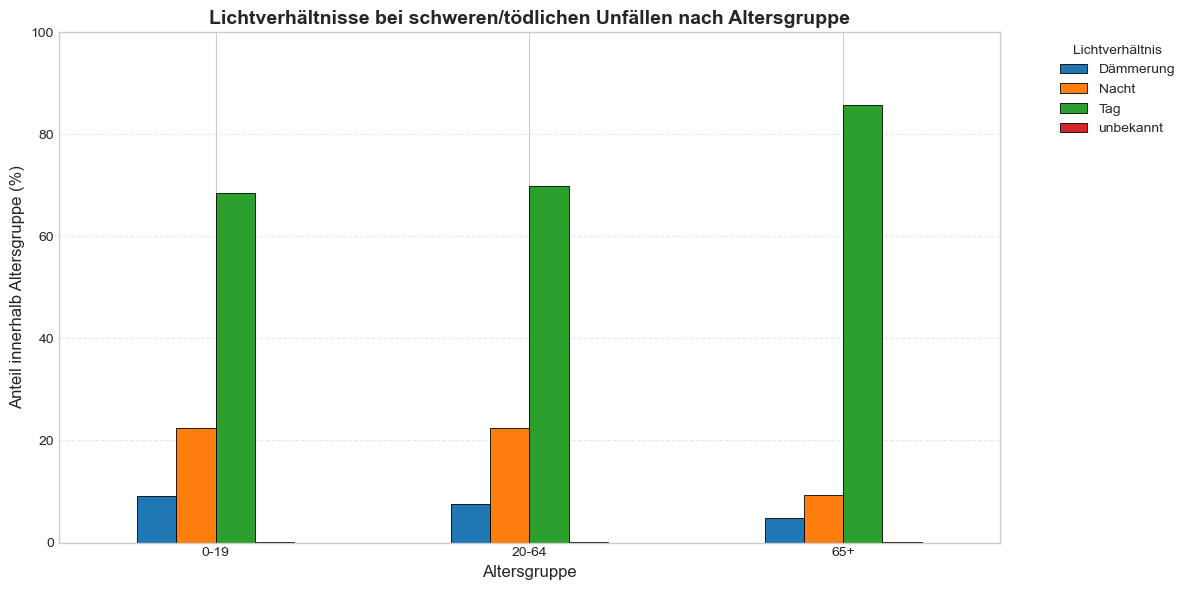


Lichtverhältnisse bei schweren/tödlichen Unfällen (%):
Lichtverhältnis  Dämmerung  Nacht   Tag  unbekannt
age_group                                         
0-19                   9.1   22.4  68.4        0.1
20-64                  7.6   22.4  69.9        0.1
65+                    4.9    9.3  85.7        0.1


In [24]:
# Filter for severe/fatal accidents with valid light conditions and age group
df_light_severe = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Lichtverhältnis"].notna()) &
    (df_filt["age_group"].notna())
].copy()

# Create crosstab normalized by age group
light_by_age = pd.crosstab(
    df_light_severe["age_group"],
    df_light_severe["Lichtverhältnis"],
    normalize='index'
) * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

light_by_age.plot(
    kind='bar',
    ax=ax,
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel("Altersgruppe", fontsize=12)
ax.set_ylabel("Anteil innerhalb Altersgruppe (%)", fontsize=12)
ax.set_title("Lichtverhältnisse bei schweren/tödlichen Unfällen nach Altersgruppe", fontsize=14, fontweight="bold")

ax.legend(title="Lichtverhältnis", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig("plots/lichtverhaeltnisse_altersgruppen.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\nLichtverhältnisse bei schweren/tödlichen Unfällen (%):")
print("="*80)
print(light_by_age.round(1))
print("="*80)

### 6.4 Regionaler Vergleich: Unfälle mit Senioren als Lenker nach Kanton

Vergleich der Unfallhäufigkeiten mit Senioren als Lenker über die Schweizer Kantone, mit Fokus auf die Top 10 Kantone mit den meisten Vorfällen. Ein Vorher/Nachher-2019-Vergleich kann Politik- oder Demografietrends aufzeigen.

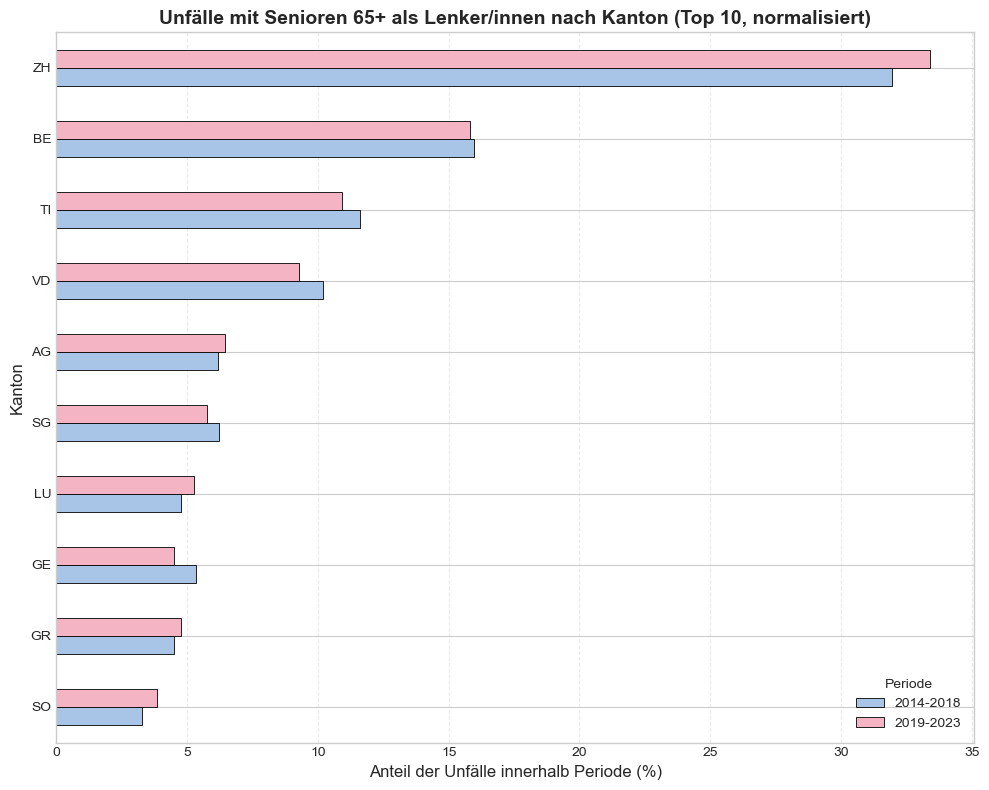


Top 10 Kantone mit Unfällen von Senioren 65+ als Lenker/innen (normalisiert):

Prozentanteile:
Periode       2014-2018  2019-2023
Unfallkanton                      
SO                  3.3        3.8
GR                  4.5        4.8
GE                  5.3        4.5
LU                  4.8        5.3
SG                  6.2        5.8
AG                  6.2        6.4
VD                 10.2        9.3
TI                 11.6       10.9
BE                 16.0       15.8
ZH                 31.9       33.4

--------------------------------------------------------------------------------

Absolute Zahlen:
Periode       2014-2018  2019-2023  Total
Unfallkanton                             
ZH                13135      14041  27176
BE                 6574       6638  13212
TI                 4782       4587   9369
VD                 4200       3898   8098
AG                 2539       2705   5244
SG                 2564       2419   4983
LU                 1958       2212   4170
GE    

In [25]:
# Filter for senior drivers with valid canton and year
df_canton = df_filt[
    (df_filt["Personenart"] == "Lenker/in") &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD) &
    (df_filt["Unfallkanton"].notna()) &
    (df_filt["Unfalljahr"].notna())
].copy()

# Create time period: before 2019 vs 2019 onwards
df_canton["Periode"] = df_canton["Unfalljahr"].apply(lambda x: "2014-2018" if x < 2019 else "2019-2023")

# Get top 10 cantons by total accidents
top_cantons = df_canton["Unfallkanton"].value_counts().head(TOP_N_CANTONS).index

df_canton_top = df_canton[df_canton["Unfallkanton"].isin(top_cantons)]

# Create crosstab and normalize by period (to show distribution across cantons)
canton_period = pd.crosstab(df_canton_top["Unfallkanton"], df_canton_top["Periode"])

# Calculate percentages within each period
canton_pct = canton_period.div(canton_period.sum(axis=0), axis=1) * 100

# Sort by total percentage
canton_pct["Total"] = canton_pct.sum(axis=1)
canton_pct = canton_pct.sort_values("Total", ascending=True)
canton_pct = canton_pct.drop("Total", axis=1)

# Also keep raw counts for display
canton_period = canton_period.loc[canton_pct.index]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

canton_pct.plot(
    kind='barh',
    ax=ax,
    color=[COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel("Anteil der Unfälle innerhalb Periode (%)", fontsize=12)
ax.set_ylabel("Kanton", fontsize=12)
ax.set_title("Unfälle mit Senioren 65+ als Lenker/innen nach Kanton (Top 10, normalisiert)", fontsize=14, fontweight="bold")

ax.legend(title="Periode", loc="lower right")
ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("plots/unfaelle_senioren_kantone.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nTop 10 Kantone mit Unfällen von Senioren 65+ als Lenker/innen (normalisiert):")
print("="*80)
print("\nProzentanteile:")
print(canton_pct.round(1))
print("\n" + "-"*80)
print("\nAbsolute Zahlen:")
canton_summary = canton_period.copy()
canton_summary["Total"] = canton_summary.sum(axis=1)
canton_summary = canton_summary.sort_values("Total", ascending=False)
print(canton_summary)
print("="*80)
print(f"\nTotal Unfälle mit Senioren als Lenker in Top 10 Kantonen: {canton_summary['Total'].sum():,}")

## 7. Verantwortlichkeitsanalyse: Senioren als Lenker bei schweren/tödlichen Unfällen

Untersuchung des Anteils schwerer/tödlicher Unfälle, bei denen Senioren als Lenker als Hauptverursacher identifiziert werden, aufgeschlüsselt nach Alters-Untergruppen (65-69, 70-74, 75+) im Zeitverlauf.

In [26]:
# ---------------------------------------------
# Filter: only severe or fatal accidents
# ---------------------------------------------
# Assuming you already have df_filt and Unfallfolgen_Gruppen created with your mapping
severe_mask = df_filt["Unfallfolgen_Gruppen"].isin([
    "erheblich / schwer verletzt",      # severely / seriously injured
    "lebensdrohlich / tödlich"         # life-threatening / fatal
])

df_severe = df_filt[severe_mask].copy()

# Keep only seniors as Lenker/in [drivers] and non-missing years + age
df_severe = df_severe[
    (df_severe["Personenart"] == "Lenker/in") &   # Lenker/in [driver]
    df_severe["Unfalljahr"].notna() &
    df_severe["Alter"].notna()
].copy()

# Age groups for drivers: 65–69, 70–74, 75+
age_groups = {
    "65-69": (65, 69),
    "70-74": (70, 74),
    "75+":   (75, 200)
}

years = sorted(df_severe["Unfalljahr"].unique())

# Prepare data structure: for each age group & year, % ja / nein
resp_share_severe = {g: {"ja": [], "nein": []} for g in age_groups}

for year in years:
    df_y = df_severe[df_severe["Unfalljahr"] == year]

    for g, (a_min, a_max) in age_groups.items():
        df_group = df_y[(df_y["Alter"] >= a_min) & (df_y["Alter"] <= a_max)]

        total = len(df_group)
        if total == 0:
            resp_share_severe[g]["ja"].append(0)
            resp_share_severe[g]["nein"].append(0)
            continue

        ja_count = len(df_group[df_group["Hauptverursacher"] == "ja"])
        nein_count = len(df_group[df_group["Hauptverursacher"] == "nein"])

        resp_share_severe[g]["ja"].append(ja_count * 100 / total)
        resp_share_severe[g]["nein"].append(nein_count * 100 / total)

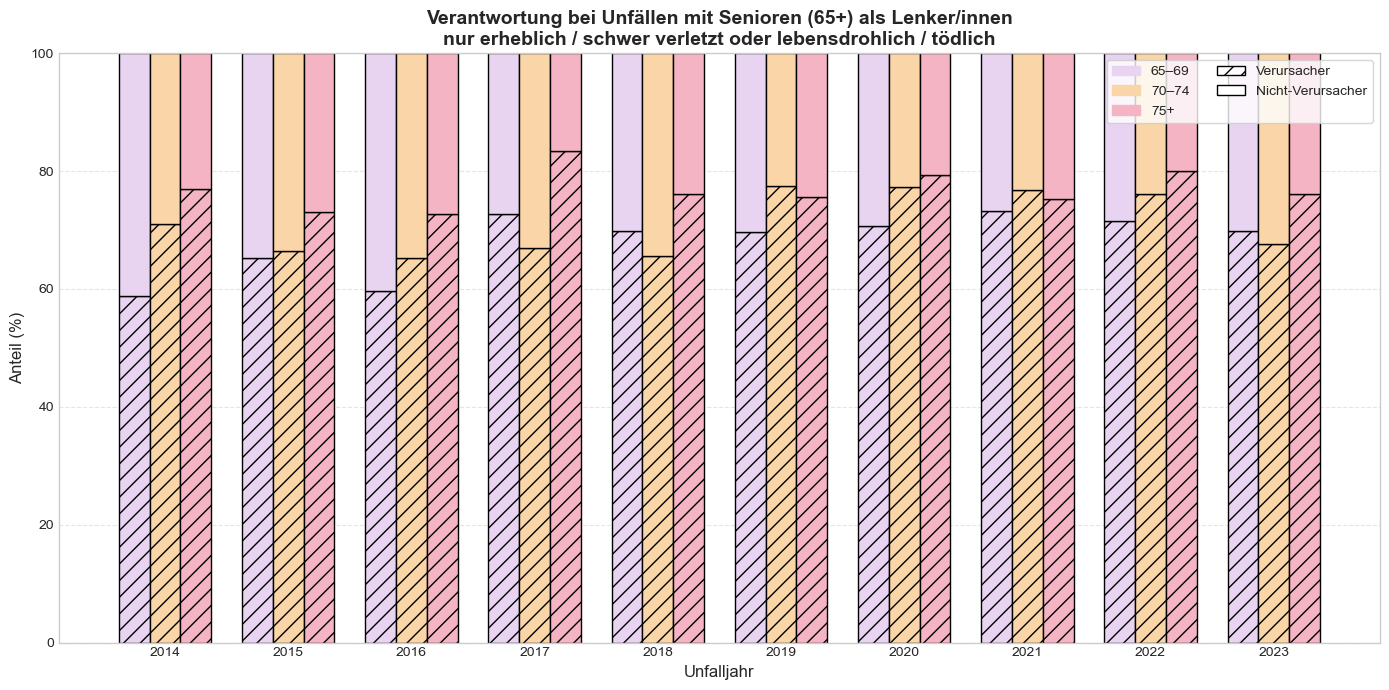

In [27]:
x = np.arange(len(years))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

# Base colors for age groups from our palette
colors = {
    "65-69": COLOR_PALETTE['age_65_69'],
    "70-74": COLOR_PALETTE['age_70_74'],
    "75+":   COLOR_PALETTE['age_75plus']
}

# One unified hatch pattern for Verursacher
hatch_pattern = "//"

offsets = [-width, 0, width]

for (g, off) in zip(age_groups.keys(), offsets):

    ja_vals   = resp_share_severe[g]["ja"]
    nein_vals = resp_share_severe[g]["nein"]

    # Verursacher (hatched)
    ax.bar(
        x + off,
        ja_vals,
        width,
        color=colors[g],
        edgecolor="black",
        hatch=hatch_pattern
    )

    # Nicht-Verursacher (solid)
    ax.bar(
        x + off,
        nein_vals,
        width,
        bottom=ja_vals,
        color=colors[g],
        edgecolor="black"
    )

# Labels & axes
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_xlabel("Unfalljahr", fontsize=12)
ax.set_ylabel("Anteil (%)", fontsize=12)
ax.set_title(
    "Verantwortung bei Unfällen mit Senioren (65+) als Lenker/innen\n"
    "nur erheblich / schwer verletzt oder lebensdrohlich / tödlich",
    fontsize=14,
    fontweight="bold"
)

ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# ---- CUSTOM CLEAN LEGEND ----
import matplotlib.patches as mpatches

# Age-group patches (solid)
lg_age = [
    mpatches.Patch(color=colors["65-69"], label="65–69"),
    mpatches.Patch(color=colors["70-74"], label="70–74"),
    mpatches.Patch(color=colors["75+"],   label="75+"),
]

# Responsibility patches (white background)
lg_resp = [
    mpatches.Patch(facecolor="white", edgecolor="black",
                   hatch=hatch_pattern, label="Verursacher"),
    mpatches.Patch(facecolor="white", edgecolor="black",
                   label="Nicht-Verursacher")
]

ax.legend(handles=lg_age + lg_resp,
          ncol=2, fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("plots/verantwortung_senioren_lenker.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Zusammenfassung und wichtigste Erkenntnisse

Diese Analyse der Schweizer Strassenverkehrsunfalldaten (2014–2023) zeigt mehrere wichtige Muster bezüglich älterer Verkehrsteilnehmer:

**Teilnahmemuster:**
- Senioren (65+) haben unterschiedliche Verkehrsteilnahmemuster im Vergleich zu jüngeren Altersgruppen, mit unterschiedlichen Verteilungen über Lenker/in, Mitfahrer/in, Fussgänger/in und Velofahrer/in-Rollen.

**Unfalltypen:**
- Bestimmte Unfalltypengruppen sind bei Senioren häufiger vertreten, was auf spezifische Risikoszenarien hinweist, die für Interventionen gezielt werden könnten.
- Die Häufigkeitstabellen zeigen, welche Manöver oder Situationen am häufigsten zu Unfällen mit älteren Verkehrsteilnehmern führen.

**Zeitliche Muster:**
- Die Tageszeitanalyse zeigt, wann Senioren am aktivsten auf den Strassen sind und wann schwere Unfälle auftreten, was sich von den Mustern der Erwachsenen unterscheiden kann.
- Trends über den Zeitraum 2014-2023 zeigen die Entwicklung von Unfällen mit Senioren als Fussgänger und Velofahrende.

**Umweltkontext:**
- Die Unfallschwere variiert je nach innerorts/ausserorts-Umgebung, mit unterschiedlichen Risikoprofilen für Senioren in verschiedenen Umgebungen.
- Witterung, Strassenzustand und Beleuchtung spielen wichtige Rollen bei schweren/tödlichen Unfällen mit Senioren.
- Altersbedingte Sehveränderungen können bestimmte Lichtverhältnisse besonders herausfordernd für ältere Fahrer machen.

**Regionale Unterschiede:**
- Die kantonale Analyse zeigt geografische Konzentration von Unfällen mit Senioren als Lenker, mit bemerkenswerten Unterschieden zwischen früheren (2014-2018) und späteren (2019-2023) Perioden.

**Verantwortlichkeit:**
- Der Anteil schwerer/tödlicher Unfälle, bei denen Senioren als Lenker als verantwortlich identifiziert werden, variiert nach Alters-Untergruppe (65-69, 70-74, 75+), was Erkenntnisse für gezielte Sicherheitsprogramme liefert.

**Implikationen für die Politik:**
- Diese Erkenntnisse können gezielte Verkehrssicherheitsinterventionen, Infrastrukturverbesserungen und Bildungsprogramme informieren, die speziell für ältere Verkehrsteilnehmer konzipiert sind.
- Das Verständnis der spezifischen Kontexte (Zeit, Ort, Bedingungen), in denen Senioren höheren Risiken ausgesetzt sind, ermöglicht wirksamere Präventionsstrategien.